https://www.unb.ca/cic/datasets/iotdataset-2023.html

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Path to your dataset folder
dataset_folder = r"C:\Users\ulami\Desktop\datasety\CIC_IOT"

# Load and concatenate all CSV files
def load_dataset(folder):
    all_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.csv')]
    dataframes = [pd.read_csv(f) for f in all_files]
    return pd.concat(dataframes, ignore_index=True)

# Load data
data = load_dataset(dataset_folder)

In [3]:
data.shape

(8405533, 40)

In [4]:
data = data.drop_duplicates()

In [5]:
data.shape

(5052844, 40)

In [12]:
# Handling missing values
data = data.dropna()

In [13]:
data.shape

(5052660, 41)

In [8]:
print(data['Label'].value_counts())

Label
BENIGN                     1094626
DDOS-ICMP_FLOOD             427956
DDOS-UDP_FLOOD              400278
DDOS-SYN_FLOOD              352988
DOS-UDP_FLOOD               350566
DDOS-PSHACK_FLOOD           342435
DDOS-TCP_FLOOD              325352
DDOS-RSTFINFLOOD            281782
DDOS-SYNONYMOUSIP_FLOOD     263094
DOS-TCP_FLOOD               230386
DOS-SYN_FLOOD               217552
MIRAI-GREETH_FLOOD          151952
MIRAI-UDPPLAIN              134792
MIRAI-GREIP_FLOOD           115547
DDOS-ICMP_FRAGMENTATION      70528
VULNERABILITYSCAN            57895
MITM-ARPSPOOFING             44665
DDOS-ACK_FRAGMENTATION       44507
DDOS-UDP_FRAGMENTATION       44383
DNS_SPOOFING                 27354
RECON-HOSTDISCOVERY          20983
RECON-OSSCAN                 14914
RECON-PORTSCAN               12538
DOS-HTTP_FLOOD               11175
DDOS-HTTP_FLOOD               4460
DDOS-SLOWLORIS                3669
DICTIONARYBRUTEFORCE          2081
BROWSERHIJACKING               918
SQLINJECTION  

In [8]:
import pandas as pd

# assuming your dataframe is called df
data['binary_label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [9]:
print(data['binary_label'].value_counts())

binary_label
1    3958081
0    1094626
Name: count, dtype: int64


In [10]:
data.isnull().sum()

Header_Length      0
Protocol Type      0
Time_To_Live       0
Rate               0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IGMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Variance           0
Label              0
binary_label       0
dtype: int64

In [11]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna()
data.shape

(5052707, 41)

In [14]:
# Separate features and labels
X = data.drop(columns=['Label', 'binary_label']).values
y = data['binary_label'].values

# OPTUNA

In [17]:
import optuna
from optuna.integration import TFKerasPruningCallback
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# Model factory
# ---------------------------
def create_model(trial, input_dim):
    model = Sequential()
    n_layers = trial.suggest_int("n_layers", 2, 6)
    for i in range(n_layers):
        units = trial.suggest_categorical(f"n_units_l{i}", [8, 16, 32, 64, 128])
        dropout_rate = trial.suggest_categorical(f"dropout_l{i}", [0.0, 0.1, 0.2])

        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation='relu'))

        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# 2) Optuna objective with Stratified K-Fold on trainval
#    + collect out-of-fold predictions to build one CV report per trial
# ---------------------------
trial_reports = []

def objective(trial):
    n_epochs   = trial.suggest_int("epochs", 5, 10)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Out-of-fold (OOF) predictions aligned to y_trainval
    oof_pred = np.full(shape=y_trainval.shape[0], fill_value=np.nan, dtype=float)

    fold_f1s = []
    folds_meta = []
    for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(X_trainval, y_trainval), start=1):
        X_tr, X_va = X_trainval[tr_idx], X_trainval[va_idx]
        y_tr, y_va = y_trainval[tr_idx], y_trainval[va_idx]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_va = scaler.transform(X_va)

        model = create_model(trial, input_dim=X_tr.shape[1])

        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
        pruning_cb = TFKerasPruningCallback(trial, "val_accuracy")

        model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=n_epochs,
            batch_size=32,
            verbose=0,
            callbacks=[early_stop, pruning_cb]
        )

        va_prob = model.predict(X_va, verbose=1).ravel()
        oof_pred[va_idx] = va_prob
        va_pred = (va_prob > 0.5).astype(int)

        rep = classification_report(y_va, va_pred, output_dict=True, zero_division=0)
        f1_macro = rep['macro avg']['f1-score']
        fold_f1s.append(f1_macro)
        folds_meta.append({'fold': fold_idx, 'f1_macro': float(f1_macro)})

        trial.report(np.mean(fold_f1s), step=fold_idx)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Build ONE report per trial from OOF predictions (same structure you used before)
    assert not np.isnan(oof_pred).any(), "OOF predictions not fully filled"
    oof_label = (oof_pred > 0.5).astype(int)
    cv_report = classification_report(y_trainval, oof_label, output_dict=True, zero_division=0)

    # Save exactly the fields your flattening code expects
    trial_reports.append({
        'trial_number': trial.number,
        'params': trial.params,
        'report': cv_report,   # has keys: 'accuracy', 'macro avg', '0', '1', ...
        'folds': folds_meta,
        'mean_f1_macro': float(np.mean(fold_f1s))
    })

    return float(np.mean(fold_f1s))

# ---------------------------
# 3) Run optimization
# ---------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_trial.params)
print(f"Best CV macro F1: {study.best_value:.4f}")


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-13 17:55:17,437] A new study created in memory with name: no-name-8398b1dc-3213-4b92-b244-da2adfed9fe8
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 579us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 26:20 38ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 26s 616us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:09 47ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 562us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-13 18:48:04,751] Trial 0 finished with value: 0.9599926859812884 and parameters: {'epochs': 10, 'n_layers': 5, 'n_units_l0': 8, 'dropout_l0': 0.2, 'n_units_l1': 128, 'dropout_l1': 0.1, 'n_units_l2': 16, 'dropout_l2': 0.2, 'n_units_l3': 64, 'dropout_l3': 0.1, 'n_units_l4': 128, 'dropout_l4': 0.2}. Best is trial 0 with value: 0.9599926859812884.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 539us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:39 48ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 26s 614us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:13 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 514us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-13 19:30:15,689] Trial 1 finished with value: 0.9650035247541021 and parameters: {'epochs': 7, 'n_layers': 4, 'n_units_l0': 8, 'dropout_l0': 0.0, 'n_units_l1': 16, 'dropout_l1': 0.2, 'n_units_l2': 64, 'dropout_l2': 0.2, 'n_units_l3': 128, 'dropout_l3': 0.0}. Best is trial 1 with value: 0.9650035247541021.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 26s 628us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 34:03 49ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 28s 669us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:19 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 581us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-13 20:03:16,356] Trial 2 finished with value: 0.9654054545606341 and parameters: {'epochs': 5, 'n_layers': 6, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 16, 'dropout_l1': 0.0, 'n_units_l2': 128, 'dropout_l2': 0.1, 'n_units_l3': 128, 'dropout_l3': 0.2, 'n_units_l4': 128, 'dropout_l4': 0.2, 'n_units_l5': 8, 'dropout_l5': 0.2}. Best is trial 2 with value: 0.9654054545606341.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 570us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 27:55 40ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 539us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:24 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 549us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-13 21:03:24,578] Trial 3 finished with value: 0.9682484828001123 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 64, 'dropout_l0': 0.2, 'n_units_l1': 8, 'dropout_l1': 0.1, 'n_units_l2': 64, 'dropout_l2': 0.1, 'n_units_l3': 64, 'dropout_l3': 0.0}. Best is trial 3 with value: 0.9682484828001123.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 521us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

   67/42106 ━━━━━━━━━━━━━━━━━━━━ 32s 774us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 495us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 23:08 33ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 507us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-13 21:50:39,075] Trial 4 finished with value: 0.965487777317254 and parameters: {'epochs': 8, 'n_layers': 3, 'n_units_l0': 16, 'dropout_l0': 0.2, 'n_units_l1': 128, 'dropout_l1': 0.2, 'n_units_l2': 16, 'dropout_l2': 0.2}. Best is trial 3 with value: 0.9682484828001123.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-13 21:52:32,198] Trial 5 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass

42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 574us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:07 47ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 514us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 30:58 44ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 525us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-13 22:54:57,524] Trial 7 finished with value: 0.9683519090625113 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 8, 'dropout_l1': 0.0, 'n_units_l2': 32, 'dropout_l2': 0.1, 'n_units_l3': 32, 'dropout_l3': 0.2}. Best is trial 7 with value: 0.9683519090625113.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-13 22:57:02,197] Trial 8 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\

42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 565us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 24:46 35ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 540us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 23:09 33ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 536us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-13 23:49:30,113] Trial 10 finished with value: 0.9689276793958691 and parameters: {'epochs': 9, 'n_layers': 2, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 32, 'dropout_l1': 0.0}. Best is trial 10 with value: 0.9689276793958691.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 540us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 20:53 30ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 520us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:37 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 20s 485us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 00:38:48,023] Trial 11 finished with value: 0.9694601252819431 and parameters: {'epochs': 9, 'n_layers': 2, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 32, 'dropout_l1': 0.0}. Best is trial 11 with value: 0.9694601252819431.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-14 00:42:22,343] Trial 12 pruned. Trial was pruned at epoch 1.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argu

42106/42106 ━━━━━━━━━━━━━━━━━━━━ 20s 483us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:09 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 550us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:27 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 530us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 01:29:57,460] Trial 14 finished with value: 0.9689098753437606 and parameters: {'epochs': 8, 'n_layers': 2, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 32, 'dropout_l1': 0.0}. Best is trial 11 with value: 0.9694601252819431.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 562us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:11 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 552us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 24:48 35ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 19s 461us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 02:20:52,726] Trial 15 finished with value: 0.9693689599133228 and parameters: {'epochs': 9, 'n_layers': 3, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 32, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0}. Best is trial 11 with value: 0.9694601252819431.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 492us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:46 48ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 521us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 23:28 33ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 558us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 03:05:40,543] Trial 16 finished with value: 0.969285400424151 and parameters: {'epochs': 8, 'n_layers': 3, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0}. Best is trial 11 with value: 0.9694601252819431.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-14 03:11:11,289] Trial 17 pruned. Trial was pruned at epoch 2.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pa

42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 513us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

   74/42106 ━━━━━━━━━━━━━━━━━━━━ 29s 697us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 20s 481us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 23:06 33ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 20s 467us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 04:03:08,373] Trial 19 finished with value: 0.9691482863170956 and parameters: {'epochs': 8, 'n_layers': 2, 'n_units_l0': 64, 'dropout_l0': 0.0, 'n_units_l1': 32, 'dropout_l1': 0.0}. Best is trial 11 with value: 0.9694601252819431.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 508us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:24 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 550us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:25 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 508us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 04:43:05,091] Trial 20 finished with value: 0.9689279276619639 and parameters: {'epochs': 7, 'n_layers': 3, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 16, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0}. Best is trial 11 with value: 0.9694601252819431.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 536us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 24:40 35ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 487us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:21 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 502us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 05:27:31,161] Trial 21 finished with value: 0.9694636079277884 and parameters: {'epochs': 8, 'n_layers': 3, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0}. Best is trial 21 with value: 0.9694636079277884.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 516us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:22 48ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 533us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 36:20 52ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 558us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 06:20:04,049] Trial 22 finished with value: 0.9697384482587686 and parameters: {'epochs': 9, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 22 with value: 0.9697384482587686.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 506us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:40 48ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 525us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:40 48ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 549us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 07:07:57,928] Trial 23 finished with value: 0.9692162014234732 and parameters: {'epochs': 8, 'n_layers': 5, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0, 'n_units_l4': 32, 'dropout_l4': 0.0}. Best is trial 22 with value: 0.9697384482587686.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 521us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:09 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 564us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 21:32 31ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 25s 583us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 08:00:21,928] Trial 24 finished with value: 0.9693662886609773 and parameters: {'epochs': 9, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 22 with value: 0.9697384482587686.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 489us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 20:57 30ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 551us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 17:02 24ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 547us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 08:44:05,044] Trial 25 finished with value: 0.9694270067605423 and parameters: {'epochs': 8, 'n_layers': 2, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.0}. Best is trial 22 with value: 0.9697384482587686.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 531us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:10 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 521us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:27 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 578us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 09:42:08,469] Trial 26 finished with value: 0.9698493209017051 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 26 with value: 0.9698493209017051.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-14 09:44:07,992] Trial 27 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\co

42106/42106 ━━━━━━━━━━━━━━━━━━━━ 25s 593us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:13 47ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 533us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 532us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 10:43:44,619] Trial 28 finished with value: 0.9698004916759023 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 64, 'dropout_l1': 0.1, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 26 with value: 0.9698493209017051.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 574us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:05 47ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 25s 582us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 30:12 43ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 25s 594us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 11:44:08,618] Trial 29 finished with value: 0.9698568759053455 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 128, 'dropout_l1': 0.1, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 29 with value: 0.9698568759053455.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 543us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 28:55 41ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 532us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 32:21 46ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 25s 582us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 12:44:43,653] Trial 30 finished with value: 0.9692415917626915 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 128, 'dropout_l1': 0.1, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 29 with value: 0.9698568759053455.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 518us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 27:49 40ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 498us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:23 48ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 22s 518us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 13:45:13,405] Trial 31 finished with value: 0.9696243848013211 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 128, 'dropout_l1': 0.1, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 29 with value: 0.9698568759053455.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 24s 565us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 33:21 48ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 23s 537us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

    1/42106 ━━━━━━━━━━━━━━━━━━━━ 22:24 32ms/step

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


42106/42106 ━━━━━━━━━━━━━━━━━━━━ 21s 486us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-14 14:45:29,799] Trial 32 finished with value: 0.9696884800632143 and parameters: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 128, 'dropout_l1': 0.1, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}. Best is trial 29 with value: 0.9698568759053455.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-14 14:47:31,402] Trial 33 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\c

Best params: {'epochs': 10, 'n_layers': 4, 'n_units_l0': 128, 'dropout_l0': 0.0, 'n_units_l1': 128, 'dropout_l1': 0.1, 'n_units_l2': 8, 'dropout_l2': 0.0, 'n_units_l3': 8, 'dropout_l3': 0.0}
Best CV macro F1: 0.9699


In [18]:
# Po zakończeniu study.optimize(...)

# Przekształcenie do DataFrame: jeden wiersz = jeden trial
flattened_reports = []
for entry in trial_reports:
    flat = {
        'trial_number': entry['trial_number'],
        **entry['params'],
        'accuracy': entry['report']['accuracy'],
        'macro_f1': entry['report']['macro avg']['f1-score'],
        'macro_precision': entry['report']['macro avg']['precision'],
        'macro_recall': entry['report']['macro avg']['recall'],
        'class_0_f1': entry['report']['0']['f1-score'],
        'class_1_f1': entry['report']['1']['f1-score']
    }
    flattened_reports.append(flat)

df_reports = pd.DataFrame(flattened_reports)
df_reports.to_csv('optuna_CIC_IoT_classification_reports.csv', index=False)

print("Zapisano raporty do: optuna_CIC_IoT_classification_reports.csv")


Zapisano raporty do: optuna_5G_NIDD_classification_reports.csv


In [19]:
scaler_full = StandardScaler().fit(X_trainval)
X_trainval_scaled = scaler_full.transform(X_trainval)
X_test_scaled = scaler_full.transform(X_test)

best_model = create_model(study.best_trial, input_dim=X_trainval_scaled.shape[1])
best_model.fit(
    X_trainval_scaled, y_trainval,
    epochs=study.best_trial.params['epochs'],
    batch_size=32,
    verbose=0
)


y_test_pred = (best_model.predict(X_test_scaled, verbose=0).ravel() > 0.5).astype(int)
final_report = classification_report(y_test, y_test_pred, zero_division=0)
print("Final Test Set Report:")
print(final_report)

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Test Set Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    218925
           1       1.00      0.97      0.99    791607

    accuracy                           0.98   1010532
   macro avg       0.96      0.98      0.97   1010532
weighted avg       0.98      0.98      0.98   1010532



In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


Test Accuracy: 97.85%
Test Precision: 97.99%
Test Recall: 97.85%


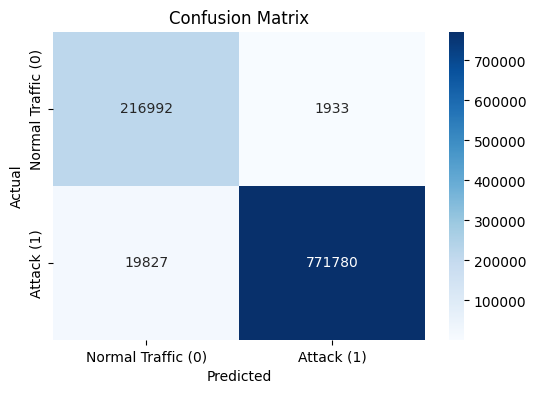

                precision    recall  f1-score   support

Normal Traffic       0.92      0.99      0.95    218925
        Attack       1.00      0.97      0.99    791607

      accuracy                           0.98   1010532
     macro avg       0.96      0.98      0.97   1010532
  weighted avg       0.98      0.98      0.98   1010532



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_test_pred, target_names=['Normal Traffic', 'Attack']))


In [20]:
import optuna.visualization as vis
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

In [21]:
optuna.visualization.plot_param_importances(study).show()


In [22]:
fig3 = optuna.visualization.plot_parallel_coordinate(study)
fig3.show()

fig4 = optuna.visualization.plot_slice(study)
fig4.show()

# FGSM

In [17]:
from tensorflow import keras

# load model
final_model = keras.models.load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\CIC_IOT_csv_final.keras")

In [34]:
X_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance
0,25.60,6,67.20,111.733096,0.0,0.10,0.0,0.10,0.60,0.0,...,1.00,8010,60,2962,801.00,1015.627338,801.00,0.008950,10,1.031499e+06
1,32.00,6,64.00,905.799374,0.0,0.00,0.0,0.00,1.00,0.0,...,1.00,20932,1514,4410,2093.20,1221.060814,2093.20,0.001122,10,1.490990e+06
2,32.00,6,80.80,931.177763,0.0,0.00,0.0,0.00,1.00,0.0,...,1.00,25276,66,5858,2527.60,1936.690602,2527.60,0.001091,10,3.750770e+06
3,32.00,6,232.00,1419.440252,0.0,0.00,0.0,0.00,1.00,0.0,...,1.00,660,66,66,66.00,0.000000,66.00,0.000814,10,0.000000e+00
4,32.00,6,181.20,211.585617,0.0,0.00,0.0,0.00,1.00,0.0,...,1.00,3556,66,1514,355.60,610.530407,355.60,0.004726,10,3.727474e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405519,20.48,6,69.22,9392.265490,0.0,0.00,0.0,0.01,0.04,0.0,...,1.00,6157,60,199,61.57,13.919868,61.57,0.000106,100,1.937627e+02
8405522,0.44,1,65.70,22638.872996,0.0,0.01,0.0,0.00,0.01,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000044,100,0.000000e+00
8405525,0.00,1,64.00,172392.272914,0.0,0.00,0.0,0.00,0.00,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000006,100,0.000000e+00
8405527,0.00,1,64.00,6412.328390,0.0,0.00,0.0,0.00,0.00,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000156,100,0.000000e+00


In [14]:
# Separate features and labels
X_df = data.drop(columns=['Label', 'binary_label'])
y = data['binary_label'].values

X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y, test_size=0.2, stratify=y, random_state=42
)

selected_features = ['Number', 'HTTPS', 'Header_Length', 'IAT', 
                    'ack_flag_number', 'Rate', 'Time_To_Live', 'ack_count', 'Tot sum', 'Tot size', 'Max', 'Std', 'Variance', 'AVG', 'Min']
print("Selected features:", selected_features)

Xtr_sel = X_trainval_df[selected_features].values
Xte_sel = X_test_df[selected_features].values

scaler_full = StandardScaler().fit(Xtr_sel)
Xtr_sel = scaler_full.transform(Xtr_sel)
Xte_sel = scaler_full.transform(Xte_sel)

Selected features: ['Number', 'HTTPS', 'Header_Length', 'IAT', 'ack_flag_number', 'Rate', 'Time_To_Live', 'ack_count', 'Tot sum', 'Tot size', 'Max', 'Std', 'Variance', 'AVG', 'Min']


In [15]:
# Separate attack and normal samples
X_test_attack = Xte_sel[y_test == 1]
y_test_attack = y_test[y_test == 1]

X_test_normal = Xte_sel[y_test == 0]
y_test_normal = y_test[y_test == 0]

In [49]:
import tensorflow as tf
import numpy as np

# Separate attack and normal samples
X_test_attack = Xte_sel[y_test == 1]
y_test_attack = y_test[y_test == 1]

X_test_normal = Xte_sel[y_test == 0]
y_test_normal = y_test[y_test == 0]

# Convert to tensors
X_attack_tensor = tf.convert_to_tensor(X_test_attack, dtype=tf.float32)
y_attack_tensor = tf.convert_to_tensor(y_test_attack.astype(np.float32))  # <- remove .values

# FGSM
def fgsm_attack(model, X, y, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
        loss = tf.keras.losses.binary_crossentropy(tf.reshape(y, (-1, 1)), predictions)
    gradient = tape.gradient(loss, X)
    signed_grad = tf.sign(gradient)
    X_adv = X + epsilon * signed_grad
    return X_adv.numpy()

# Generate adversarial attack examples
epsilon = 0.3
X_attack_adv = fgsm_attack(final_model, X_attack_tensor, y_attack_tensor, epsilon=epsilon)

# Combine normal and adversarial attack samples back together
X_test_combined = np.vstack((X_test_normal, X_attack_adv))
y_test_combined = np.hstack((y_test_normal, y_test_attack))

# shuffle the test set
from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(X_test_combined, y_test_combined, random_state=42)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")

31580/31580 ━━━━━━━━━━━━━━━━━━━━ 18s 566us/step
Test Accuracy: 99.02%
Test Precision: 99.03%
Test Recall: 99.02%


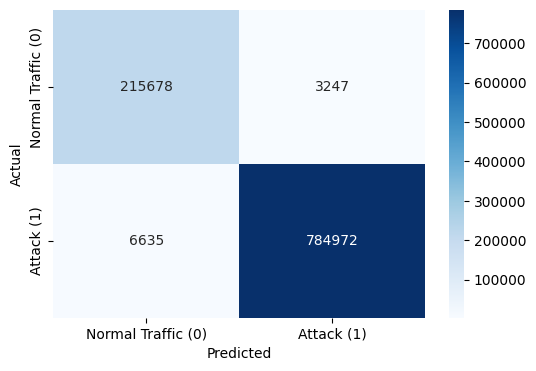

                precision    recall  f1-score   support

Normal Traffic       0.97      0.99      0.98    218925
        Attack       1.00      0.99      0.99    791607

      accuracy                           0.99   1010532
     macro avg       0.98      0.99      0.99   1010532
  weighted avg       0.99      0.99      0.99   1010532



In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [39]:
Xte_sel.shape

(1010532, 15)

In [40]:
X_test_adv_final.shape

(1010532, 15)

In [41]:
import numpy as np
import pandas as pd

# Predictions on the (scaled) originals and adversarials
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# Masks for transitions
mask_1_to_0 = (orig_pred == 1) & (adv_pred == 0)  # attack → normal
mask_0_to_1 = (orig_pred == 0) & (adv_pred == 1)  # normal → attack (on the same attack samples)

n_1_to_0 = int(mask_1_to_0.sum())
n_0_to_1 = int(mask_0_to_1.sum())

# Optional: unchanged counts
n_1_to_1 = int(((orig_pred == 1) & (adv_pred == 1)).sum())
n_0_to_0 = int(((orig_pred == 0) & (adv_pred == 0)).sum())

total = len(orig_pred)

print(f"Total attack samples: {total}")
print(f"Flipped 1→0 (attack→normal): {n_1_to_0} ({n_1_to_0/total:.2%})")
print(f"Flipped 0→1 (normal→attack): {n_0_to_1} ({n_0_to_1/total:.2%})")
print(f"Stayed 1→1: {n_1_to_1} ({n_1_to_1/total:.2%})")
print(f"Stayed 0→0: {n_0_to_0} ({n_0_to_0/total:.2%})")

# Optional: a tidy 2×2 table of transitions
transition = pd.crosstab(pd.Series(orig_pred, name="orig"),
                         pd.Series(adv_pred,  name="adv"))
print("\nTransition table (orig → adv):\n", transition)


Total attack samples: 791607
Flipped 1→0 (attack→normal): 3483 (0.44%)
Flipped 0→1 (normal→attack): 16049 (2.03%)
Stayed 1→1: 768923 (97.13%)
Stayed 0→0: 3152 (0.40%)

Transition table (orig → adv):
 adv      0       1
orig              
0     3152   16049
1     3483  768923


In [44]:
import numpy as np
import pandas as pd

# idx_test comes from your split (same as before)
idx_test = X_test_df.index

# Get both original string labels and binary labels for the test set
label_str_test = data.loc[idx_test, "Label"].reset_index(drop=True)
binary_label_test = data.loc[idx_test, "binary_label"].reset_index(drop=True)

# Sanity check
assert len(label_str_test) == len(y_test) == len(binary_label_test), \
    "Test labels length mismatch. Check idx_test alignment."

# ------------------------------------------------------------
# 2) Narrow to the ATTACK subset (binary=1)
# ------------------------------------------------------------
label_str_attack = label_str_test[binary_label_test == 1].reset_index(drop=True)

# mask_0_to_1 already defined as:
# mask_0_to_1 = (orig_pred == 0) & (adv_pred == 1)

# ------------------------------------------------------------
# 3) Which attack strings flipped 0→1?
# ------------------------------------------------------------
flipped_attack_strings = label_str_attack[mask_0_to_1]

flip_counts = (
    flipped_attack_strings
    .value_counts()
    .rename_axis("orig_label")
    .to_frame("flip_count")
)

if len(flipped_attack_strings) > 0:
    flip_counts["flip_pct_of_0to1"] = (
        100.0 * flip_counts["flip_count"] / len(flipped_attack_strings)
    )

print("\n0→1 flips by original attack label (true attacks only):")
print(flip_counts.sort_values(["flip_count", "orig_label"], ascending=[False, True]).head(30))

# ------------------------------------------------------------
# 4) Flip RATE per attack type
# ------------------------------------------------------------
attack_totals = (
    label_str_attack
    .value_counts()
    .rename_axis("orig_label")
    .to_frame("attacked_total")
)

rate_table = attack_totals.join(flip_counts, how="left").fillna({"flip_count": 0})
rate_table["flip_rate_%"] = 100.0 * rate_table["flip_count"] / rate_table["attacked_total"]
rate_table = rate_table.sort_values("flip_rate_%", ascending=False)

print("\nFlip rate (0→1) by original attack label (flips / attacked_total):")
print(rate_table.head(30))

# ------------------------------------------------------------
# 5) Aggregate by "family"
# ------------------------------------------------------------
def get_family(label: str) -> str:
    if "-" in label:
        return label.split("-", 1)[0]
    if "_" in label:
        return label.split("_", 1)[0]
    return label

family_attack = label_str_attack.map(get_family)
family_flipped = flipped_attack_strings.map(get_family)

family_totals = family_attack.value_counts().rename_axis("family").to_frame("attacked_total")
family_flips = family_flipped.value_counts().rename_axis("family").to_frame("flip_count")

family_rates = family_totals.join(family_flips, how="left").fillna({"flip_count": 0})
family_rates["flip_rate_%"] = 100.0 * family_rates["flip_count"] / family_rates["attacked_total"]
family_rates = family_rates.sort_values("flip_rate_%", ascending=False)

print("\nFlip rate (0→1) by attack family:")
print(family_rates)

# ------------------------------------------------------------
# 6) Get indices of flipped samples
# ------------------------------------------------------------
attack_pos_in_test = np.flatnonzero(binary_label_test == 1)
flip_pos_in_test = attack_pos_in_test[np.flatnonzero(mask_0_to_1)]
flip_raw_indices = np.array(idx_test)[flip_pos_in_test]

print("\nNumber of 0→1 flips on attacks:", len(flip_pos_in_test))
print("Example raw indices of flips (first 20):", flip_raw_indices[:20])



0→1 flips by original attack label (true attacks only):
                      flip_count  flip_pct_of_0to1
orig_label                                        
VULNERABILITYSCAN           7287         45.404698
MITM-ARPSPOOFING            2327         14.499346
RECON-OSSCAN                1672         10.418095
RECON-HOSTDISCOVERY         1465          9.128295
DNS_SPOOFING                1338          8.336968
RECON-PORTSCAN              1147          7.146863
DICTIONARYBRUTEFORCE         279          1.738426
SQLINJECTION                 127          0.791327
COMMANDINJECTION              97          0.604399
BROWSERHIJACKING              87          0.542090
XSS                           82          0.510935
BACKDOOR_MALWARE              64          0.398779
RECON-PINGSWEEP               43          0.267929
UPLOADING_ATTACK              28          0.174466
DOS-UDP_FLOOD                  4          0.024924
DDOS-PSHACK_FLOOD              1          0.006231
DDOS-UDP_FLOOD           

In [50]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

orig_scores_attack = final_model.predict(X_test_attack, verbose=0).ravel()
adv_scores_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()
orig_pred_attack = (orig_scores_attack >= 0.5).astype(int)
adv_pred_attack  = (adv_scores_attack  >= 0.5).astype(int)


# ------------------------------------------------------------
# 1. Build a DataFrame for attack subset with predictions
#    (uses: label_str_attack, y_test_attack, orig_pred_attack, adv_pred_attack)
# ------------------------------------------------------------
df_attack_eval = pd.DataFrame({
    "orig_label_str": label_str_attack,   # original multi-class labels for the attack subset
    "y_true": y_test_attack,              # all 1's (true attacks)
    "y_pred_clean": orig_pred_attack,     # predictions on clean attack samples
    "y_pred_adv": adv_pred_attack         # predictions on FGSM-perturbed attack samples
})

# ------------------------------------------------------------
# 2. Compute per-original-attack-class recall before & after FGSM
# ------------------------------------------------------------
results = []
for attack_type, group in df_attack_eval.groupby("orig_label_str", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    # With all y_true==1, recall is well-defined; precision isn't.
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    results.append({
        "attack_type": attack_type,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

results_df = pd.DataFrame(results).sort_values("recall_diff", ascending=False)

print("\nPer-class recall before vs. after FGSM (attack subset only):")
print(results_df)

# ------------------------------------------------------------
# 3. (Optional) Aggregate by attack family (DDOS, DOS, RECON, etc.)
# ------------------------------------------------------------
def get_family(label: str) -> str:
    if "-" in label:
        return label.split("-", 1)[0]
    if "_" in label:
        return label.split("_", 1)[0]
    return label

df_attack_eval["family"] = df_attack_eval["orig_label_str"].map(get_family)

family_results = []
for fam, group in df_attack_eval.groupby("family", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    family_results.append({
        "family": fam,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

family_df = pd.DataFrame(family_results).sort_values("recall_diff", ascending=False)

print("\nPer-family recall before vs. after FGSM:")
print(family_df)



Per-class recall before vs. after FGSM (attack subset only):
                attack_type  n_samples  recall_clean  recall_adv  recall_diff
22             SQLINJECTION        171      0.169591    0.888889     0.719298
29         UPLOADING_ATTACK         42      0.238095    0.904762     0.666667
28     DICTIONARYBRUTEFORCE        414      0.193237    0.842995     0.649758
31                      XSS        125      0.176000    0.808000     0.632000
32          RECON-PINGSWEEP         70      0.185714    0.785714     0.600000
25         BACKDOOR_MALWARE        105      0.285714    0.866667     0.580952
4         VULNERABILITYSCAN      11598      0.271340    0.850319     0.578979
30         BROWSERHIJACKING        160      0.281250    0.787500     0.506250
12             RECON-OSSCAN       3056      0.306283    0.775196     0.468914
26         COMMANDINJECTION        179      0.351955    0.759777     0.407821
20           RECON-PORTSCAN       2529      0.449585    0.786081     0.336497
19

# TEST EPSILON VALUES

    epsilon  attack_precision  attack_recall  attack_f1
0     0.005          0.995802       0.973091   0.984316
1     0.010          0.995798       0.972029   0.983770
2     0.020          0.995823       0.977787   0.986722
3     0.050          0.995865       0.987974   0.991904
4     0.100          0.995877       0.990771   0.993317
5     0.300          0.995881       0.991618   0.993745
6     0.500          0.995883       0.992149   0.994012
7     1.000          0.995886       0.992820   0.994350
8     1.500          0.995882       0.991868   0.993871
9     5.000          0.995873       0.989867   0.992861
10   10.000          0.995874       0.990010   0.992933


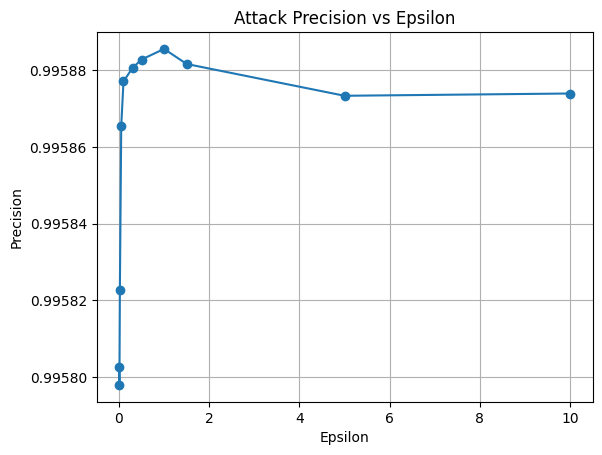

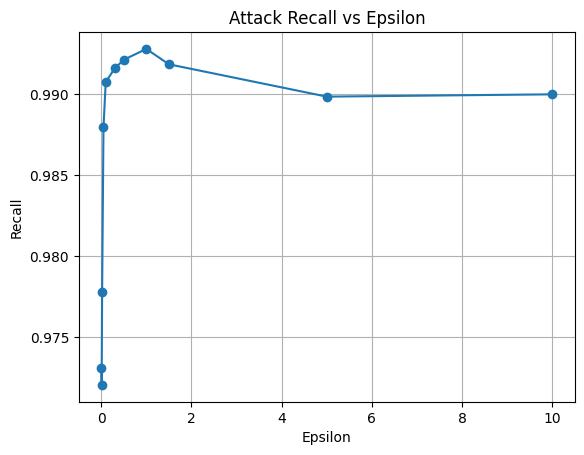

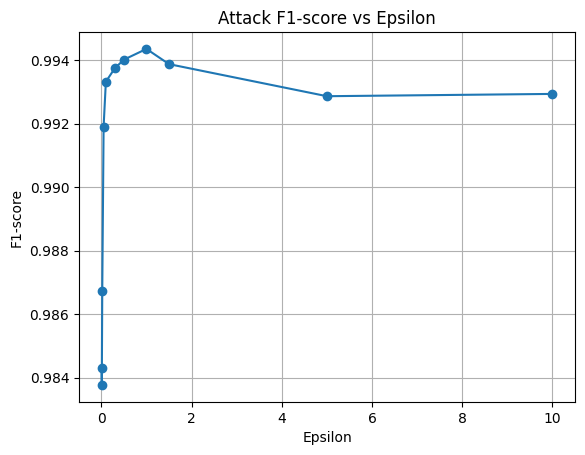

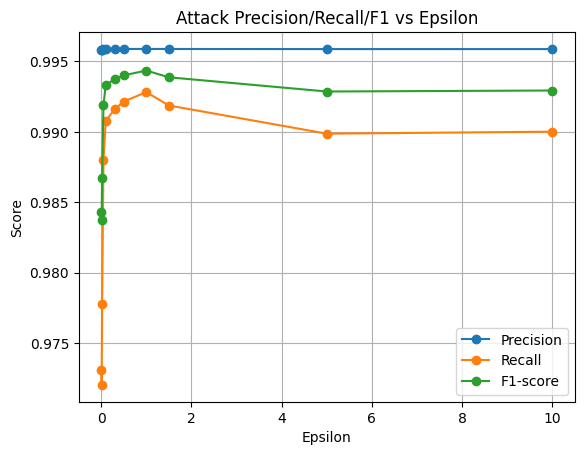

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Epsilons to test
epsilons = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 5.0, 10.0]

results = []

for eps in epsilons:
    # 1) Generate adversarial attack examples for this epsilon (attack subset only)
    X_attack_adv = fgsm_attack(final_model, X_attack_tensor, y_attack_tensor, epsilon=eps)

    # 2) Combine benign (unchanged) with adversarial attacks
    X_test_combined = np.vstack((X_test_normal, X_attack_adv))
    y_test_combined = np.hstack((y_test_normal, y_test_attack))  # 0 for normal, 1 for attack

    # 3) Shuffle (keep reproducible)
    X_test_adv_final, y_test_adv_final = shuffle(X_test_combined, y_test_combined, random_state=42)

    # 4) Predict and binarize
    y_pred = final_model.predict(X_test_adv_final, verbose=0).ravel()
    y_pred_bin = (y_pred >= 0.5).astype(int)

    # 5) Compute Attack (positive class = 1) metrics
    prec = precision_score(y_test_adv_final, y_pred_bin, pos_label=1, zero_division=0)
    rec  = recall_score(y_test_adv_final, y_pred_bin,    pos_label=1, zero_division=0)
    f1   = f1_score(y_test_adv_final, y_pred_bin,        pos_label=1, zero_division=0)

    results.append({"epsilon": eps, "attack_precision": prec, "attack_recall": rec, "attack_f1": f1})

# Put in a DataFrame
metrics_df = pd.DataFrame(results).sort_values("epsilon").reset_index(drop=True)
print(metrics_df)

# -------------------------
# Plots
# -------------------------

# 1) Attack precision vs epsilon
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_precision"], marker="o")
plt.title("Attack Precision vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 2) Attack recall vs epsilon
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_recall"], marker="o")
plt.title("Attack Recall vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Recall")
plt.grid(True)
plt.show()

# 3) Attack F1-score vs epsilon
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_f1"], marker="o")
plt.title("Attack F1-score vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

# 4) All three metrics on one plot
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_precision"], marker="o", label="Precision")
plt.plot(metrics_df["epsilon"], metrics_df["attack_recall"],    marker="o", label="Recall")
plt.plot(metrics_df["epsilon"], metrics_df["attack_f1"],        marker="o", label="F1-score")
plt.title("Attack Precision/Recall/F1 vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
eps = 0.01

# 1) Generate adversarial attack examples for this epsilon (attack subset only)
X_attack_adv = fgsm_attack(final_model, X_attack_tensor, y_attack_tensor, epsilon=eps)

# 2) Combine benign (unchanged) with adversarial attacks
X_test_combined = np.vstack((X_test_normal, X_attack_adv))
y_test_combined = np.hstack((y_test_normal, y_test_attack))  # 0 for normal, 1 for attack

# 3) Shuffle (keep reproducible)
X_test_adv_final, y_test_adv_final = shuffle(X_test_combined, y_test_combined, random_state=42)

# 4) Predict and binarize
y_pred = final_model.predict(X_test_adv_final, verbose=0).ravel()
y_pred_bin = (y_pred >= 0.5).astype(int)

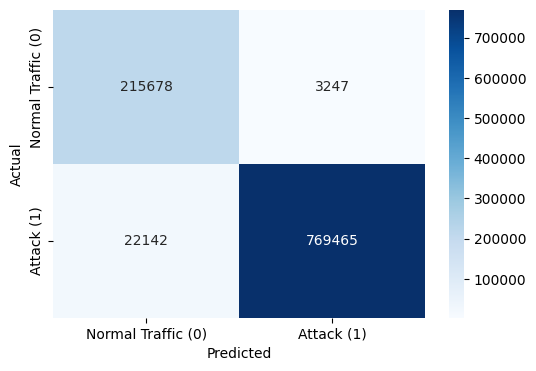

                precision    recall  f1-score   support

Normal Traffic       0.91      0.99      0.94    218925
        Attack       1.00      0.97      0.98    791607

      accuracy                           0.97   1010532
     macro avg       0.95      0.98      0.96   1010532
  weighted avg       0.98      0.97      0.98   1010532



In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred_bin)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred_bin, target_names=['Normal Traffic', 'Attack']))


In [55]:
import numpy as np
import pandas as pd

# Predictions on the (scaled) originals and adversarials
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# Masks for transitions
mask_1_to_0 = (orig_pred == 1) & (adv_pred == 0)  # attack → normal
mask_0_to_1 = (orig_pred == 0) & (adv_pred == 1)  # normal → attack (on the same attack samples)

n_1_to_0 = int(mask_1_to_0.sum())
n_0_to_1 = int(mask_0_to_1.sum())

# Optional: unchanged counts
n_1_to_1 = int(((orig_pred == 1) & (adv_pred == 1)).sum())
n_0_to_0 = int(((orig_pred == 0) & (adv_pred == 0)).sum())

total = len(orig_pred)

print(f"Total attack samples: {total}")
print(f"Flipped 1→0 (attack→normal): {n_1_to_0} ({n_1_to_0/total:.2%})")
print(f"Flipped 0→1 (normal→attack): {n_0_to_1} ({n_0_to_1/total:.2%})")
print(f"Stayed 1→1: {n_1_to_1} ({n_1_to_1/total:.2%})")
print(f"Stayed 0→0: {n_0_to_0} ({n_0_to_0/total:.2%})")

# Optional: a tidy 2×2 table of transitions
transition = pd.crosstab(pd.Series(orig_pred, name="orig"),
                         pd.Series(adv_pred,  name="adv"))
print("\nTransition table (orig → adv):\n", transition)


Total attack samples: 791607
Flipped 1→0 (attack→normal): 3732 (0.47%)
Flipped 0→1 (normal→attack): 791 (0.10%)
Stayed 1→1: 768674 (97.10%)
Stayed 0→0: 18410 (2.33%)

Transition table (orig → adv):
 adv       0       1
orig               
0     18410     791
1      3732  768674


In [57]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# ------------------------------------------------------------
# 1. Build a DataFrame for attack subset with predictions
#    (uses: label_str_attack, y_test_attack, orig_pred_attack, adv_pred_attack)
# ------------------------------------------------------------
df_attack_eval = pd.DataFrame({
    "orig_label_str": label_str_attack,   # original multi-class labels for the attack subset
    "y_true": y_test_attack,              # all 1's (true attacks)
    "y_pred_clean": orig_pred,     # predictions on clean attack samples
    "y_pred_adv": adv_pred         # predictions on FGSM-perturbed attack samples
})

# ------------------------------------------------------------
# 2. Compute per-original-attack-class recall before & after FGSM
# ------------------------------------------------------------
results = []
for attack_type, group in df_attack_eval.groupby("orig_label_str", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    # With all y_true==1, recall is well-defined; precision isn't.
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    results.append({
        "attack_type": attack_type,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

results_df = pd.DataFrame(results).sort_values("recall_diff", ascending=False)

print("\nPer-class recall before vs. after FGSM (attack subset only):")
print(results_df)

# ------------------------------------------------------------
# 3. (Optional) Aggregate by attack family (DDOS, DOS, RECON, etc.)
# ------------------------------------------------------------
def get_family(label: str) -> str:
    if "-" in label:
        return label.split("-", 1)[0]
    if "_" in label:
        return label.split("_", 1)[0]
    return label

df_attack_eval["family"] = df_attack_eval["orig_label_str"].map(get_family)

family_results = []
for fam, group in df_attack_eval.groupby("family", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    family_results.append({
        "family": fam,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

family_df = pd.DataFrame(family_results).sort_values("recall_diff", ascending=False)

print("\nPer-family recall before vs. after FGSM:")
print(family_df)



Per-class recall before vs. after FGSM (attack subset only):
                attack_type  n_samples  recall_clean  recall_adv  recall_diff
0            DDOS-TCP_FLOOD      65028      1.000000    1.000000     0.000000
2         DDOS-PSHACK_FLOOD      68466      0.999985    0.999985     0.000000
3   DDOS-SYNONYMOUSIP_FLOOD      52659      1.000000    1.000000     0.000000
15        MIRAI-GREIP_FLOOD      23044      0.999957    0.999957     0.000000
11            DOS-SYN_FLOOD      43697      1.000000    1.000000     0.000000
13           DOS-HTTP_FLOOD       2220      0.999099    0.999099     0.000000
14  DDOS-ICMP_FRAGMENTATION      13994      0.999929    0.999929     0.000000
21   DDOS-ACK_FRAGMENTATION       8931      1.000000    1.000000     0.000000
24           DDOS-SLOWLORIS        724      1.000000    1.000000     0.000000
27          DDOS-HTTP_FLOOD        861      1.000000    1.000000     0.000000
1          DDOS-RSTFINFLOOD      56240      1.000000    0.999982    -0.000018
8 

# Targeted FGSM → benign (class 0)

In [58]:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle

def targeted_fgsm_to_benign(model, X, epsilon):
    """
    Targeted FGSM toward benign (class 0).
    Uses target label 0 and *minimizes* the loss for that target:
      X_adv = X - epsilon * sign(grad_x J(x, y_target=0))
    """
    # y_target = 0 for every sample
    y_target = tf.zeros((tf.shape(X)[0], 1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X)
        preds = model(X)
        # model should output probabilities in shape (N,1); if logits, use from_logits=True
        loss = tf.keras.losses.binary_crossentropy(y_target, preds)  # per-sample
        # If loss returns shape (N,), make it explicit:
        loss = tf.reduce_mean(loss)

    grad = tape.gradient(loss, X)

    # Targeted step: subtract gradient sign to minimize target-0 loss
    signed_grad = tf.sign(grad)
    X_adv = X - epsilon * signed_grad
    return X_adv.numpy()

# Generate targeted adversarial examples (push attacks -> benign)
epsilon = 0.3
X_attack_adv = targeted_fgsm_to_benign(final_model, X_attack_tensor, epsilon=epsilon)

# Combine normal and adversarial attack samples back together (unchanged)
X_test_combined = np.vstack((X_test_normal, X_attack_adv))
y_test_combined = np.hstack((y_test_normal, y_test_attack))

# Shuffle (unchanged)
X_test_adv_final, y_test_adv_final = shuffle(X_test_combined, y_test_combined, random_state=42)


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")

31580/31580 ━━━━━━━━━━━━━━━━━━━━ 17s 538us/step
Test Accuracy: 97.26%
Test Precision: 97.46%
Test Recall: 97.26%


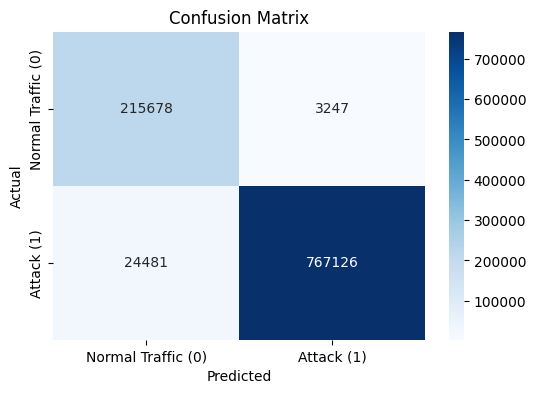

                precision    recall  f1-score   support

Normal Traffic       0.90      0.99      0.94    218925
        Attack       1.00      0.97      0.98    791607

      accuracy                           0.97   1010532
     macro avg       0.95      0.98      0.96   1010532
  weighted avg       0.97      0.97      0.97   1010532



In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [61]:
import numpy as np
import pandas as pd

# Predictions on the (scaled) originals and adversarials
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# Masks for transitions
mask_1_to_0 = (orig_pred == 1) & (adv_pred == 0)  # attack → normal
mask_0_to_1 = (orig_pred == 0) & (adv_pred == 1)  # normal → attack (on the same attack samples)

n_1_to_0 = int(mask_1_to_0.sum())
n_0_to_1 = int(mask_0_to_1.sum())

# Optional: unchanged counts
n_1_to_1 = int(((orig_pred == 1) & (adv_pred == 1)).sum())
n_0_to_0 = int(((orig_pred == 0) & (adv_pred == 0)).sum())

total = len(orig_pred)

print(f"Total attack samples: {total}")
print(f"Flipped 1→0 (attack→normal): {n_1_to_0} ({n_1_to_0/total:.2%})")
print(f"Flipped 0→1 (normal→attack): {n_0_to_1} ({n_0_to_1/total:.2%})")
print(f"Stayed 1→1: {n_1_to_1} ({n_1_to_1/total:.2%})")
print(f"Stayed 0→0: {n_0_to_0} ({n_0_to_0/total:.2%})")

# Optional: a tidy 2×2 table of transitions
transition = pd.crosstab(pd.Series(orig_pred, name="orig"),
                         pd.Series(adv_pred,  name="adv"))
print("\nTransition table (orig → adv):\n", transition)


Total attack samples: 791607
Flipped 1→0 (attack→normal): 21329 (2.69%)
Flipped 0→1 (normal→attack): 16049 (2.03%)
Stayed 1→1: 751077 (94.88%)
Stayed 0→0: 3152 (0.40%)

Transition table (orig → adv):
 adv       0       1
orig               
0      3152   16049
1     21329  751077


In [62]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# ------------------------------------------------------------
# 1. Build a DataFrame for attack subset with predictions
#    (uses: label_str_attack, y_test_attack, orig_pred_attack, adv_pred_attack)
# ------------------------------------------------------------
df_attack_eval = pd.DataFrame({
    "orig_label_str": label_str_attack,   # original multi-class labels for the attack subset
    "y_true": y_test_attack,              # all 1's (true attacks)
    "y_pred_clean": orig_pred,     # predictions on clean attack samples
    "y_pred_adv": adv_pred         # predictions on FGSM-perturbed attack samples
})

# ------------------------------------------------------------
# 2. Compute per-original-attack-class recall before & after FGSM
# ------------------------------------------------------------
results = []
for attack_type, group in df_attack_eval.groupby("orig_label_str", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    # With all y_true==1, recall is well-defined; precision isn't.
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    results.append({
        "attack_type": attack_type,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

results_df = pd.DataFrame(results).sort_values("recall_diff", ascending=False)

print("\nPer-class recall before vs. after FGSM (attack subset only):")
print(results_df)

# ------------------------------------------------------------
# 3. (Optional) Aggregate by attack family (DDOS, DOS, RECON, etc.)
# ------------------------------------------------------------
def get_family(label: str) -> str:
    if "-" in label:
        return label.split("-", 1)[0]
    if "_" in label:
        return label.split("_", 1)[0]
    return label

df_attack_eval["family"] = df_attack_eval["orig_label_str"].map(get_family)

family_results = []
for fam, group in df_attack_eval.groupby("family", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    family_results.append({
        "family": fam,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

family_df = pd.DataFrame(family_results).sort_values("recall_diff", ascending=False)

print("\nPer-family recall before vs. after FGSM:")
print(family_df)



Per-class recall before vs. after FGSM (attack subset only):
                attack_type  n_samples  recall_clean  recall_adv  recall_diff
22             SQLINJECTION        171      0.169591    0.888889     0.719298
29         UPLOADING_ATTACK         42      0.238095    0.904762     0.666667
28     DICTIONARYBRUTEFORCE        414      0.193237    0.842995     0.649758
31                      XSS        125      0.176000    0.808000     0.632000
32          RECON-PINGSWEEP         70      0.185714    0.785714     0.600000
25         BACKDOOR_MALWARE        105      0.285714    0.866667     0.580952
4         VULNERABILITYSCAN      11598      0.271340    0.850319     0.578979
30         BROWSERHIJACKING        160      0.281250    0.787500     0.506250
12             RECON-OSSCAN       3056      0.306283    0.775196     0.468914
26         COMMANDINJECTION        179      0.351955    0.759777     0.407821
20           RECON-PORTSCAN       2529      0.449585    0.786081     0.336497
19

# TEST EPSILON VALUES TARGETED

   epsilon  attack_precision  attack_recall  attack_f1
0     0.01          0.995798       0.972029   0.983770
1     0.02          0.995823       0.977787   0.986722
2     0.05          0.995865       0.987974   0.991904
3     0.10          0.995877       0.990756   0.993310
4     0.30          0.995785       0.969074   0.982248
5     0.50          0.995376       0.883016   0.935836
6     1.00          0.995113       0.835157   0.908145
7     1.50          0.994010       0.680718   0.808060
8     5.00          0.987546       0.325254   0.489340
9    10.00          0.987388       0.321121   0.484630


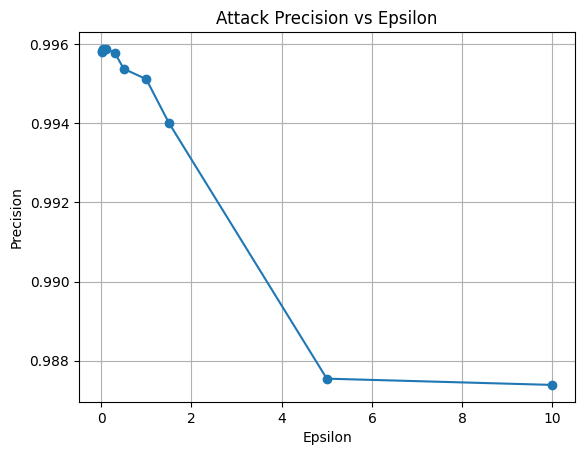

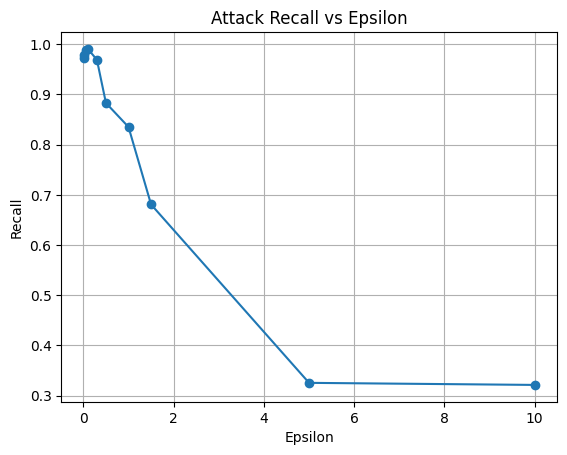

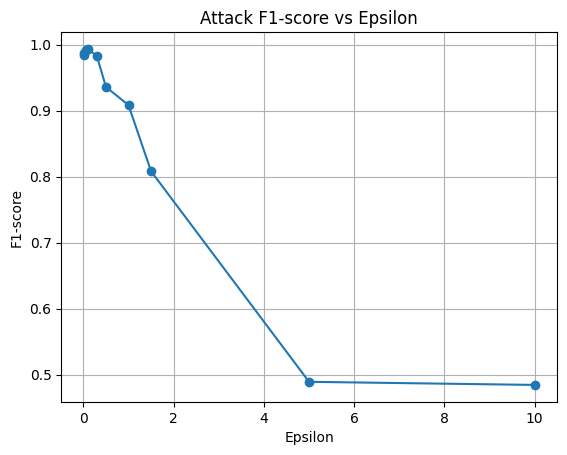

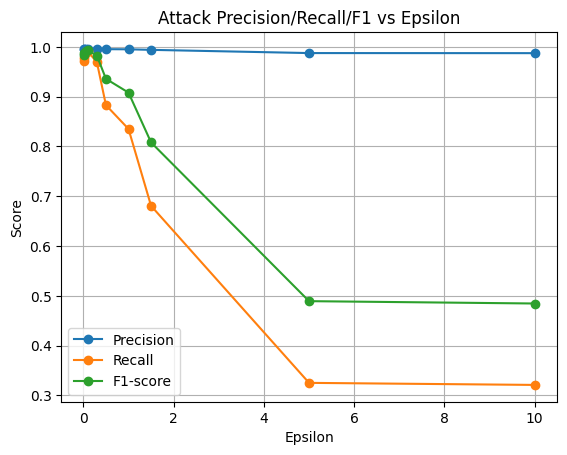

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Epsilons to test
epsilons = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 5.0, 10.0]

results = []

for eps in epsilons:
    # 1) Generate adversarial attack examples for this epsilon (attack subset only)
    X_attack_adv = targeted_fgsm_to_benign(final_model, X_attack_tensor, epsilon=eps)

    # 2) Combine benign (unchanged) with adversarial attacks
    X_test_combined = np.vstack((X_test_normal, X_attack_adv))
    y_test_combined = np.hstack((y_test_normal, y_test_attack))  # 0 for normal, 1 for attack

    # 3) Shuffle (keep reproducible)
    X_test_adv_final, y_test_adv_final = shuffle(X_test_combined, y_test_combined, random_state=42)

    # 4) Predict and binarize
    y_pred = final_model.predict(X_test_adv_final, verbose=0).ravel()
    y_pred_bin = (y_pred >= 0.5).astype(int)

    # 5) Compute Attack (positive class = 1) metrics
    prec = precision_score(y_test_adv_final, y_pred_bin, pos_label=1, zero_division=0)
    rec  = recall_score(y_test_adv_final, y_pred_bin,    pos_label=1, zero_division=0)
    f1   = f1_score(y_test_adv_final, y_pred_bin,        pos_label=1, zero_division=0)

    results.append({"epsilon": eps, "attack_precision": prec, "attack_recall": rec, "attack_f1": f1})

# Put in a DataFrame
metrics_df = pd.DataFrame(results).sort_values("epsilon").reset_index(drop=True)
print(metrics_df)

# -------------------------
# Plots
# -------------------------

# 1) Attack precision vs epsilon
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_precision"], marker="o")
plt.title("Attack Precision vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 2) Attack recall vs epsilon
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_recall"], marker="o")
plt.title("Attack Recall vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Recall")
plt.grid(True)
plt.show()

# 3) Attack F1-score vs epsilon
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_f1"], marker="o")
plt.title("Attack F1-score vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

# 4) All three metrics on one plot
plt.figure()
plt.plot(metrics_df["epsilon"], metrics_df["attack_precision"], marker="o", label="Precision")
plt.plot(metrics_df["epsilon"], metrics_df["attack_recall"],    marker="o", label="Recall")
plt.plot(metrics_df["epsilon"], metrics_df["attack_f1"],        marker="o", label="F1-score")
plt.title("Attack Precision/Recall/F1 vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


# 5.0

In [65]:
# Generate targeted adversarial examples (push attacks -> benign)
epsilon = 5.0
X_attack_adv = targeted_fgsm_to_benign(final_model, X_attack_tensor, epsilon=epsilon)

# Combine normal and adversarial attack samples back together (unchanged)
X_test_combined = np.vstack((X_test_normal, X_attack_adv))
y_test_combined = np.hstack((y_test_normal, y_test_attack))

# Shuffle (unchanged)
X_test_adv_final, y_test_adv_final = shuffle(X_test_combined, y_test_combined, random_state=42)

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")

31580/31580 ━━━━━━━━━━━━━━━━━━━━ 18s 562us/step
Test Accuracy: 46.82%
Test Precision: 83.59%
Test Recall: 46.82%


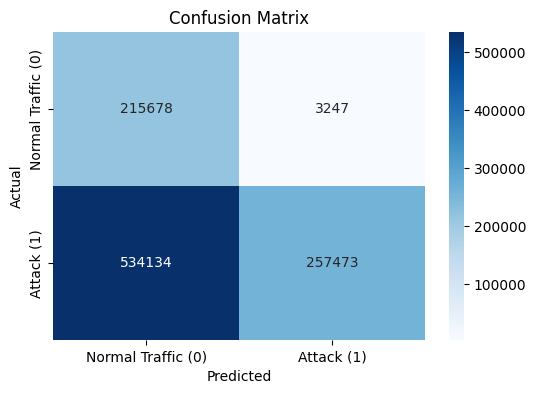

                precision    recall  f1-score   support

Normal Traffic       0.29      0.99      0.45    218925
        Attack       0.99      0.33      0.49    791607

      accuracy                           0.47   1010532
     macro avg       0.64      0.66      0.47   1010532
  weighted avg       0.84      0.47      0.48   1010532



In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [68]:
import numpy as np
import pandas as pd

# Predictions on the (scaled) originals and adversarials
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# Masks for transitions
mask_1_to_0 = (orig_pred == 1) & (adv_pred == 0)  # attack → normal
mask_0_to_1 = (orig_pred == 0) & (adv_pred == 1)  # normal → attack (on the same attack samples)

n_1_to_0 = int(mask_1_to_0.sum())
n_0_to_1 = int(mask_0_to_1.sum())

# Optional: unchanged counts
n_1_to_1 = int(((orig_pred == 1) & (adv_pred == 1)).sum())
n_0_to_0 = int(((orig_pred == 0) & (adv_pred == 0)).sum())

total = len(orig_pred)

print(f"Total attack samples: {total}")
print(f"Flipped 1→0 (attack→normal): {n_1_to_0} ({n_1_to_0/total:.2%})")
print(f"Flipped 0→1 (normal→attack): {n_0_to_1} ({n_0_to_1/total:.2%})")
print(f"Stayed 1→1: {n_1_to_1} ({n_1_to_1/total:.2%})")
print(f"Stayed 0→0: {n_0_to_0} ({n_0_to_0/total:.2%})")

# Optional: a tidy 2×2 table of transitions
transition = pd.crosstab(pd.Series(orig_pred, name="orig"),
                         pd.Series(adv_pred,  name="adv"))
print("\nTransition table (orig → adv):\n", transition)


Total attack samples: 791607
Flipped 1→0 (attack→normal): 531548 (67.15%)
Flipped 0→1 (normal→attack): 16615 (2.10%)
Stayed 1→1: 240858 (30.43%)
Stayed 0→0: 2586 (0.33%)

Transition table (orig → adv):
 adv        0       1
orig                
0       2586   16615
1     531548  240858


In [69]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# ------------------------------------------------------------
# 1. Build a DataFrame for attack subset with predictions
#    (uses: label_str_attack, y_test_attack, orig_pred_attack, adv_pred_attack)
# ------------------------------------------------------------
df_attack_eval = pd.DataFrame({
    "orig_label_str": label_str_attack,   # original multi-class labels for the attack subset
    "y_true": y_test_attack,              # all 1's (true attacks)
    "y_pred_clean": orig_pred,     # predictions on clean attack samples
    "y_pred_adv": adv_pred         # predictions on FGSM-perturbed attack samples
})

# ------------------------------------------------------------
# 2. Compute per-original-attack-class recall before & after FGSM
# ------------------------------------------------------------
results = []
for attack_type, group in df_attack_eval.groupby("orig_label_str", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    # With all y_true==1, recall is well-defined; precision isn't.
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    results.append({
        "attack_type": attack_type,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

results_df = pd.DataFrame(results).sort_values("recall_diff", ascending=False)

print("\nPer-class recall before vs. after FGSM (attack subset only):")
print(results_df)

# ------------------------------------------------------------
# 3. (Optional) Aggregate by attack family (DDOS, DOS, RECON, etc.)
# ------------------------------------------------------------
def get_family(label: str) -> str:
    if "-" in label:
        return label.split("-", 1)[0]
    if "_" in label:
        return label.split("_", 1)[0]
    return label

df_attack_eval["family"] = df_attack_eval["orig_label_str"].map(get_family)

family_results = []
for fam, group in df_attack_eval.groupby("family", sort=False):
    y_true = group["y_true"].values
    y_clean = group["y_pred_clean"].values
    y_adv   = group["y_pred_adv"].values
    
    rec_clean = recall_score(y_true, y_clean, zero_division=0)
    rec_adv   = recall_score(y_true, y_adv,   zero_division=0)
    
    family_results.append({
        "family": fam,
        "n_samples": len(group),
        "recall_clean": rec_clean,
        "recall_adv": rec_adv,
        "recall_diff": rec_adv - rec_clean
    })

family_df = pd.DataFrame(family_results).sort_values("recall_diff", ascending=False)

print("\nPer-family recall before vs. after FGSM:")
print(family_df)



Per-class recall before vs. after FGSM (attack subset only):
                attack_type  n_samples  recall_clean  recall_adv  recall_diff
22             SQLINJECTION        171      0.169591    0.894737     0.725146
31                      XSS        125      0.176000    0.880000     0.704000
29         UPLOADING_ATTACK         42      0.238095    0.928571     0.690476
32          RECON-PINGSWEEP         70      0.185714    0.857143     0.671429
28     DICTIONARYBRUTEFORCE        414      0.193237    0.859903     0.666667
25         BACKDOOR_MALWARE        105      0.285714    0.895238     0.609524
30         BROWSERHIJACKING        160      0.281250    0.837500     0.556250
4         VULNERABILITYSCAN      11598      0.271340    0.822901     0.551561
26         COMMANDINJECTION        179      0.351955    0.776536     0.424581
12             RECON-OSSCAN       3056      0.306283    0.726113     0.419830
20           RECON-PORTSCAN       2529      0.449585    0.676552     0.226967
17

In [70]:
import numpy as np
import pandas as pd

column_names = selected_features

# --- Find flips: 1 -> 0 ---
idx_flip = np.where((orig_pred == 1) & (adv_pred == 0))[0]
print(f"Total attack samples: {len(X_test_attack)}")
print(f"Flipped (1→0): {len(idx_flip)}")

if idx_flip.size == 0:
    print("No examples flipped from attack (1) to normal (0).")
else:
    # show up to N examples
    N = 10
    idx_show = idx_flip[:N]

    # inverse-transform ONLY FOR DISPLAY
    scaler_display = scaler if 'scaler' in locals() else scaler_full
    X_orig_disp = scaler_display.inverse_transform(X_test_attack[idx_show])
    X_adv_disp  = scaler_display.inverse_transform(X_attack_adv[idx_show])

    # predictions (from the already-computed probs)
    y_pred_orig = orig_pred[idx_show]
    y_pred_adv  = adv_pred[idx_show]

    # build tables like before
    df_original = pd.DataFrame(X_orig_disp, columns=column_names)
    df_original["Prediction"] = y_pred_orig

    df_adversarial = pd.DataFrame(X_adv_disp, columns=column_names)
    df_adversarial["Prediction"] = y_pred_adv

    # display settings (same style as earlier)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 6)
    pd.set_option('display.width', 100)

    print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
    print(df_original)

    print("\n🟥 Corresponding Adversarial Samples:\n")
    print(df_adversarial)

# 🟩 Normal samples for comparison (first up to 10)
n_norm = min(10, len(X_test_normal))
X_norm_scaled = X_test_normal[:n_norm]  # already scaled
scaler_display = scaler if 'scaler' in locals() else scaler_full

# Inverse-transform for display only
X_norm_disp = scaler_display.inverse_transform(X_norm_scaled)

# Predictions on scaled inputs
y_pred_norm = (final_model.predict(X_norm_scaled, verbose=0).ravel() > 0.5).astype(int)

# Build table
df_normal = pd.DataFrame(X_norm_disp, columns=column_names)
df_normal["Prediction"] = y_pred_norm

print("\n🟩 Normal Samples (benign) for comparison:\n")
print(df_normal)


Total attack samples: 791607
Flipped (1→0): 531548

🟦 Original Attack Samples (that later flipped 1→0):

   Number  HTTPS  Header_Length       IAT  ack_flag_number          Rate  Time_To_Live  ack_count  \
0   100.0   0.00          20.04  0.000072             0.01  13914.225053         63.78        1.0   
1   100.0   0.01          20.00  0.000141             0.02   7078.157855         65.47        2.0   
2   100.0   0.00          19.64  0.000377             0.00   2655.900306         65.63        0.0   
3   100.0   0.00           8.00  0.000019             0.00  51922.555088         64.00        0.0   
4   100.0   0.00          20.00  0.000023             0.00  44285.756520         64.00        0.0   
5   100.0   0.00          20.00  0.000084             0.00  11870.783687         64.00        0.0   
6   100.0   0.00           0.16  0.000504             0.00   1989.254819         64.00        0.0   
7   100.0   0.00           8.00  0.000123             0.00   8105.718427         65.28 

# FGSM REAL-LIFE

In [37]:
import numpy as np

def enforce_iot_constraints_in_scaled_space(
    X_scaled, scaler, feature_order, *, mtu=1500, min_pkt=40
):
    """
    Enforce IoT flow constraints (only on selected fields) directly in scaled space.

    Fields touched (if present in feature_order):
      - IAT:        clamp to >= 0
      - Min:        integer bytes in [min_pkt, mtu]
      - Max:        integer bytes in [Min,     mtu]  (and ensure Min <= Max)
      - AVG:        float in [Min, Max]
      - Tot size:   integer bytes in [Min, Max]
      - Std:        >= 0 and <= (Max - Min)/2
      - Variance:   set to Std**2 (kept consistent with Std)
      - Tot sum:    integer bytes; if Number present:
                       Tot sum = round(Number * AVG), then clamp to [Number*Min, Number*Max]
                    else: clamp to >= 0 (best-effort)

    Notes:
      - We DO NOT modify 'Number'. If available, we use a rounded/clipped
        'effective' value internally (>=1) to keep totals coherent.
      - If Min > Max after perturbation, we swap/order them safely.
      - If only one of (Std, Variance) exists, we derive the other to keep consistency.

    Requires a StandardScaler-like scaler with mean_ and scale_.
    """
    Xs = np.asarray(X_scaled, dtype=np.float64, order="C")

    if not hasattr(scaler, "mean_") or not hasattr(scaler, "scale_"):
        raise ValueError("This function expects a StandardScaler (with mean_ and scale_).")

    mean  = np.asarray(scaler.mean_,  dtype=np.float64)
    scale = np.asarray(scaler.scale_, dtype=np.float64)
    col   = {c: i for i, c in enumerate(feature_order)}

    def _to_orig(z, j):   return z * scale[j] + mean[j]
    def _to_scaled(x, j): return (x - mean[j]) / scale[j]
    def _rint_clip(x, lo=None, hi=None):
        x = np.rint(x)
        if lo is not None: x = np.maximum(x, lo)
        if hi is not None: x = np.minimum(x, hi)
        return x

    # ---- fetch columns (indices) if present ----
    j_IAT      = col.get("IAT")
    j_tot_sum  = col.get("Tot sum")
    j_tot_size = col.get("Tot size")
    j_max      = col.get("Max")
    j_std      = col.get("Std")
    j_var      = col.get("Variance")
    j_avg      = col.get("AVG")
    j_min      = col.get("Min")
    j_number   = col.get("Number")  # read-only helper

    # ---- read originals for the targeted fields ----
    Min  = _to_orig(Xs[:, j_min], j_min)   if j_min  is not None else None
    Max  = _to_orig(Xs[:, j_max], j_max)   if j_max  is not None else None
    AVG  = _to_orig(Xs[:, j_avg], j_avg)   if j_avg  is not None else None
    Std  = _to_orig(Xs[:, j_std], j_std)   if j_std  is not None else None
    Var  = _to_orig(Xs[:, j_var], j_var)   if j_var  is not None else None
    Tsum = _to_orig(Xs[:, j_tot_sum], j_tot_sum) if j_tot_sum is not None else None
    Tsize= _to_orig(Xs[:, j_tot_size], j_tot_size) if j_tot_size is not None else None
    IAT  = _to_orig(Xs[:, j_IAT], j_IAT)   if j_IAT  is not None else None

    # Effective Number (not written back)
    if j_number is not None:
        Number_eff = _rint_clip(_to_orig(Xs[:, j_number], j_number), lo=1)
    else:
        Number_eff = None

    n = Xs.shape[0]
    # Defaults for missing arrays when we need bounds
    if Min is None: Min = np.full(n, min_pkt, dtype=np.float64)
    if Max is None: Max = np.full(n, mtu,     dtype=np.float64)

    # ---- 1) IAT: >= 0 ----
    if IAT is not None:
        IAT = np.maximum(IAT, 0.0)
        Xs[:, j_IAT] = _to_scaled(IAT, j_IAT)

    # ---- 2) Min/Max: integer bytes, ordered, within [min_pkt, mtu] ----
    if j_min is not None:
        Min = _rint_clip(Min, lo=min_pkt, hi=mtu)
    if j_max is not None:
        Max = _rint_clip(Max, lo=min_pkt, hi=mtu)

    # Ensure Min <= Max (swap/order if needed)
    if (j_min is not None) or (j_max is not None):
        mmin = np.minimum(Min, Max)
        mmax = np.maximum(Min, Max)
        Min, Max = mmin, mmax
        if j_min is not None: Xs[:, j_min] = _to_scaled(Min, j_min)
        if j_max is not None: Xs[:, j_max] = _to_scaled(Max, j_max)

    # ---- 3) AVG: float in [Min, Max]; if missing and (Tsum & Number) exist, derive AVG ----
    if j_avg is not None:
        AVG = np.clip(AVG, Min, Max)
        Xs[:, j_avg] = _to_scaled(AVG, j_avg)
    elif (Tsum is not None) and (Number_eff is not None):
        # derive AVG when not present
        AVG = np.clip(Tsum / Number_eff, Min, Max)

    # ---- 4) Tot size: integer ∈ [Min, Max] ----
    if Tsize is not None:
        Tsize = _rint_clip(Tsize, lo=Min, hi=Max)
        Xs[:, j_tot_size] = _to_scaled(Tsize, j_tot_size)

    # ---- 5) Std / Variance: keep consistent, cap by (Max-Min)/2 ----
    width   = np.maximum(Max - Min, 0.0)
    std_cap = 0.5 * width

    # choose a candidate std
    if (Std is None) and (Var is not None):
        Std = np.sqrt(np.maximum(Var, 0.0))
    elif Std is None and Var is None:
        Std = np.zeros(n, dtype=np.float64)

    # bound std and set variance accordingly
    Std = np.clip(Std, 0.0, std_cap)
    Var = Std * Std

    if j_std is not None:
        Xs[:, j_std] = _to_scaled(Std, j_std)
    if j_var is not None:
        Xs[:, j_var] = _to_scaled(Var, j_var)

    # ---- 6) Tot sum: integer; prefer coherence with Number & AVG; clamp to [N*Min, N*Max] ----
    if j_tot_sum is not None:
        if (Number_eff is not None) and (AVG is not None):
            # target: sum = round(N * AVG)
            Tsum_new = _rint_clip(Number_eff * AVG, lo=0)
            lo = Number_eff * Min
            hi = Number_eff * Max
            # ensure within feasible envelope
            Tsum_new = np.clip(Tsum_new, lo, hi)
            Xs[:, j_tot_sum] = _to_scaled(Tsum_new, j_tot_sum)
        elif (Number_eff is not None):
            # no AVG → just clamp to feasible envelope
            Tsum = _rint_clip(Tsum, lo=0)
            lo = Number_eff * Min
            hi = Number_eff * Max
            Tsum = np.clip(Tsum, lo, hi)
            Xs[:, j_tot_sum] = _to_scaled(Tsum, j_tot_sum)
        else:
            # no Number → best-effort non-negative clamp
            Tsum = _rint_clip(Tsum, lo=0)
            Xs[:, j_tot_sum] = _to_scaled(Tsum, j_tot_sum)

    return Xs


In [79]:
import tensorflow as tf
import numpy as np


# Feature order & scaler used in training
feature_order = selected_features  # e.g. ['Offset','sTtl','sMeanPktSz','sHops','State']
scaler_project = scaler if 'scaler' in locals() else scaler_full
feat_idx = {c: i for i, c in enumerate(feature_order)}

# ---- FGSM with feature mask ----
def targeted_fgsm_to_benign(model, X, epsilon, feature_mask=None):
    """
    Targeted FGSM toward benign (class 0).
    Uses target label 0 and *minimizes* the loss for that target:
      X_adv = X - epsilon * sign(grad_x J(x, y_target=0))
    """
    # y_target = 0 for every sample
    y_target = tf.zeros((tf.shape(X)[0], 1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X)
        preds = model(X)
        loss = tf.keras.losses.binary_crossentropy(y_target, preds)
        loss = tf.reduce_mean(loss)

    gradient = tape.gradient(loss, X)

    signed_grad = tf.sign(gradient)

    if feature_mask is not None:
        signed_grad = signed_grad * tf.convert_to_tensor(feature_mask, dtype=X.dtype)
    # return (X + epsilon * signed).numpy()
    
    # if feature_mask is not None:
    #     mask = tf.reshape(tf.convert_to_tensor(feature_mask, dtype=X.dtype), (1, -1))
    #     signed_grad = signed_grad * mask  # broadcast across batch

    X_adv = X - epsilon * signed_grad
    return X_adv.numpy()

# ---- FGSM with CIC IoT realism mask (using your selected_features) ----
# feat_idx = {c: i for i, c in enumerate(selected_features)}
# # Start with all features frozen (0)
# mask_vec = np.zeros(X_test_attack.shape[1], dtype=np.float32)

# # Whitelist the 4 source-controllable features
# for feat in ['IAT', 'Tot sum', 'Tot size', 'Max', 'Std', 'Variance', 'AVG', 'Min']:
#     if feat in feat_idx:
#         mask_vec[feat_idx[feat]] = 1.0

# Build a 1/0 mask aligned to your selected_features
immutable = {'IAT', 'Tot sum', 'Tot size', 'Max', 'Std', 'Variance', 'AVG', 'Min'}  # add more names here if needed
mask_vec = np.array([1.0 if f in immutable else 0.0 for f in selected_features], dtype=np.float32)

epsilon = 5.0
X_attack_adv = targeted_fgsm_to_benign(
    final_model,
    X_attack_tensor,
    epsilon=epsilon,
    feature_mask=mask_vec
)

X_attack_adv = enforce_iot_constraints_in_scaled_space(
    X_attack_adv, scaler_project, selected_features, mtu=1500, min_pkt=40
)

# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_attack_adv))
y_test_combined = np.hstack((y_test_normal, y_test_attack))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)


In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


31580/31580 ━━━━━━━━━━━━━━━━━━━━ 17s 549us/step
Test Accuracy: 36.72%
Test Precision: 82.22%
Test Recall: 36.72%


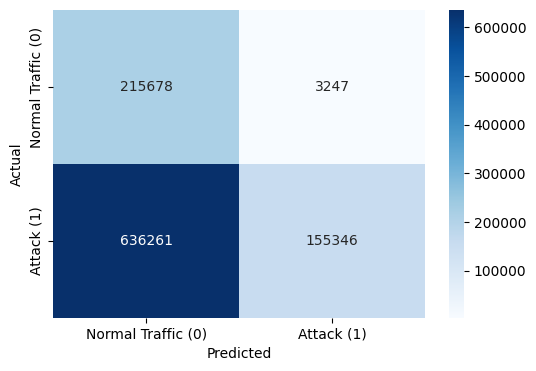

                precision    recall  f1-score   support

Normal Traffic       0.25      0.99      0.40    218925
        Attack       0.98      0.20      0.33    791607

      accuracy                           0.37   1010532
     macro avg       0.62      0.59      0.36   1010532
  weighted avg       0.82      0.37      0.34   1010532



In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
# y_pred = final_model.predict(X_test_adv_final)
# y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [78]:
import numpy as np
import pandas as pd

# Predictions on the (scaled) originals and adversarials
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# Masks for transitions
mask_1_to_0 = (orig_pred == 1) & (adv_pred == 0)  # attack → normal
mask_0_to_1 = (orig_pred == 0) & (adv_pred == 1)  # normal → attack (on the same attack samples)

n_1_to_0 = int(mask_1_to_0.sum())
n_0_to_1 = int(mask_0_to_1.sum())

# Optional: unchanged counts
n_1_to_1 = int(((orig_pred == 1) & (adv_pred == 1)).sum())
n_0_to_0 = int(((orig_pred == 0) & (adv_pred == 0)).sum())

total = len(orig_pred)

print(f"Total attack samples: {total}")
print(f"Flipped 1→0 (attack→normal): {n_1_to_0} ({n_1_to_0/total:.2%})")
print(f"Flipped 0→1 (normal→attack): {n_0_to_1} ({n_0_to_1/total:.2%})")
print(f"Stayed 1→1: {n_1_to_1} ({n_1_to_1/total:.2%})")
print(f"Stayed 0→0: {n_0_to_0} ({n_0_to_0/total:.2%})")

# Optional: a tidy 2×2 table of transitions
transition = pd.crosstab(pd.Series(orig_pred, name="orig"),
                         pd.Series(adv_pred,  name="adv"))
print("\nTransition table (orig → adv):\n", transition)


Total attack samples: 791607
Flipped 1→0 (attack→normal): 633752 (80.06%)
Flipped 0→1 (normal→attack): 16692 (2.11%)
Stayed 1→1: 138654 (17.52%)
Stayed 0→0: 2509 (0.32%)

Transition table (orig → adv):
 adv        0       1
orig                
0       2509   16692
1     633752  138654


In [82]:
import numpy as np
import pandas as pd

column_names = selected_features

# --- Predict on scaled inputs (no inverse-transform for prediction) ---
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# --- Find flips: 1 -> 0 ---
idx_flip = np.where((orig_pred == 1) & (adv_pred == 0))[0]
print(f"Total attack samples: {len(X_test_attack)}")
print(f"Flipped (1→0): {len(idx_flip)}")

if idx_flip.size == 0:
    print("No examples flipped from attack (1) to normal (0).")
else:
    # show up to N examples
    N = 10
    idx_show = idx_flip[:N]

    # inverse-transform ONLY FOR DISPLAY
    scaler_display = scaler if 'scaler' in locals() else scaler_full
    X_orig_disp = scaler_display.inverse_transform(X_test_attack[idx_show])
    X_adv_disp  = scaler_display.inverse_transform(X_attack_adv[idx_show])

    # predictions (from the already-computed probs)
    y_pred_orig = orig_pred[idx_show]
    y_pred_adv  = adv_pred[idx_show]

    # build tables like before
    df_original = pd.DataFrame(X_orig_disp, columns=column_names)
    df_original["Prediction"] = y_pred_orig

    df_adversarial = pd.DataFrame(X_adv_disp, columns=column_names)
    df_adversarial["Prediction"] = y_pred_adv

    # display settings (same style as earlier)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 6)
    pd.set_option('display.width', 100)

    print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
    print(df_original)

    print("\n🟥 Corresponding Adversarial Samples:\n")
    print(df_adversarial)

# 🟩 Normal samples for comparison (first up to 10)
n_norm = min(10, len(X_test_normal))
X_norm_scaled = X_test_normal[:n_norm]  # already scaled
scaler_display = scaler if 'scaler' in locals() else scaler_full

# Inverse-transform for display only
X_norm_disp = scaler_display.inverse_transform(X_norm_scaled)

# Predictions on scaled inputs
y_pred_norm = (final_model.predict(X_norm_scaled, verbose=0).ravel() > 0.5).astype(int)

# Build table
df_normal = pd.DataFrame(X_norm_disp, columns=column_names)
df_normal["Prediction"] = y_pred_norm

print("\n🟩 Normal Samples (benign) for comparison:\n")
print(df_normal)


Total attack samples: 791607
Flipped (1→0): 633752

🟦 Original Attack Samples (that later flipped 1→0):

   Number  HTTPS  Header_Length       IAT  ack_flag_number          Rate  Time_To_Live  ack_count  \
0   100.0   0.00          20.04  0.000072             0.01  13914.225053         63.78        1.0   
1   100.0   0.01          20.00  0.000141             0.02   7078.157855         65.47        2.0   
2   100.0   0.00          19.64  0.000377             0.00   2655.900306         65.63        0.0   
3   100.0   0.00           8.00  0.000019             0.00  51922.555088         64.00        0.0   
4   100.0   0.00          20.00  0.000023             0.00  44285.756520         64.00        0.0   
5   100.0   0.00          20.00  0.000084             0.00  11870.783687         64.00        0.0   
6   100.0   0.00          20.00  0.000032             1.00  31018.370064         64.00      100.0   
7   100.0   0.00           0.16  0.000504             0.00   1989.254819         64.00 

# ZOO

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score

# ---------- Utilities ----------
def predict_proba(model, X):
    """Return P(y=1) as a flat numpy array."""
    return model.predict(X, verbose=0).ravel()

def bce_loss(p, y):
    """Binary cross-entropy (elementwise) with clipping for numerical stability."""
    eps = 1e-7
    p = np.clip(p, eps, 1 - eps)
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

def loss_at_x(model, x, y_scalar):
    """Loss at a single point x (1D) for label y in {0,1}."""
    p = predict_proba(model, x[None, :])[0]
    return bce_loss(p, y_scalar)

def finite_diff_grad(model, x, y_scalar, h=1e-3):
    """
    Central-difference gradient of loss wrt x.
    Uses 2*d queries per call (d = number of features).
    """
    d = x.shape[0]
    batch_plus = np.repeat(x[None, :], d, axis=0)
    batch_minus = batch_plus.copy()
    for i in range(d):
        batch_plus[i, i] += h
        batch_minus[i, i] -= h

    p_plus = predict_proba(model, batch_plus)
    p_minus = predict_proba(model, batch_minus)
    L_plus = bce_loss(p_plus, np.full(d, y_scalar))
    L_minus = bce_loss(p_minus, np.full(d, y_scalar))

    # central difference derivative dL/dx_i ≈ (L(x+h e_i) - L(x-h e_i)) / (2h)
    grad = (L_plus - L_minus) / (2.0 * h)
    queries = 2 * d
    return grad, queries

def project_linf(x0, x, eps):
    """Project x to the Linf ball around x0 with radius eps."""
    return np.clip(x, x0 - eps, x0 + eps)

def project_l2(x0, x, eps):
    """Project x to the L2 ball around x0 with radius eps."""
    delta = x - x0
    norm = np.linalg.norm(delta, ord=2)
    if norm > eps:
        delta = delta * (eps / (norm + 1e-12))
    return x0 + delta

# ---------- Core ZOO attacker (single example) ----------
def zoo_attack_single(
    model,
    x0,
    y_true,
    steps=300,
    lr=0.05,
    h=1e-3,
    eps=0.5,
    norm="linf",          # "linf" or "l2"
    targeted=None,        # None for untargeted; otherwise target label in {0,1}
    clip_min=None,
    clip_max=None,
    early_stop=True
):
    """
    Runs ZOO on one sample.
    - Untargeted: ascend BCE loss for the true label until misclassification.
    - Targeted:   descend BCE loss for the chosen target label until classified as target.

    Returns: x_adv, success(bool), queries(int), iters(int)
    """
    x = x0.copy()
    queries = 0
    d = x.size

    # Choose projector
    projector = project_linf if norm == "linf" else project_l2

    # Initial check
    p0 = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred0 = int(p0 > 0.5)
    already_wrong = (y_pred0 != y_true)
    if targeted is None and already_wrong:
        return x, True, queries, 0  # already misclassified

    for t in range(1, steps + 1):
        # For targeted, define loss towards the target; for untargeted, towards the true label
        label_for_loss = targeted if targeted is not None else y_true

        # Zeroth-order gradient estimate of d(loss)/dx
        grad, q = finite_diff_grad(model, x, label_for_loss, h=h)
        queries += q

        # Update rule: untargeted -> ascend; targeted -> descend
        direction = +1.0 if targeted is None else -1.0
        x = x + direction * lr * grad

        # Project to epsilon-ball around original point
        x = projector(x0, x, eps)

        # Optional: keep within observed data range to avoid extreme z-scores
        if (clip_min is not None) and (clip_max is not None):
            x = np.minimum(np.maximum(x, clip_min), clip_max)

        # Check success condition
        p = predict_proba(model, x[None, :])[0]; queries += 1
        y_pred = int(p > 0.5)
        success = (y_pred != y_true) if targeted is None else (y_pred == targeted)

        if early_stop and success:
            return x, True, queries, t

    # End of budget
    p = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred = int(p > 0.5)
    success = (y_pred != y_true) if targeted is None else (y_pred == targeted)
    return x, success, queries, steps

# ---------- Convenience: attack a batch and summarize ----------
def run_zoo_attack(
    model,
    X,
    y,
    X_train_for_bounds=None,     # e.g., Xtr_sel to bound to observed range
    max_samples=100,
    eps=0.5,
    norm="linf",
    steps=300,
    lr=0.05,
    h=1e-3,
    targeted=None,
    only_on_correct=True,
    random_state=0
):
    rng = np.random.default_rng(random_state)

    # Bounds from training data (optional but recommended for tabular)
    if X_train_for_bounds is not None:
        clip_min = X_train_for_bounds.min(axis=0)
        clip_max = X_train_for_bounds.max(axis=0)
    else:
        clip_min = clip_max = None

    # Decide which indices to attack
    y_pred_all = (predict_proba(model, X) > 0.5).astype(int)
    if only_on_correct:
        candidates = np.where(y_pred_all == y)[0]
    else:
        candidates = np.arange(len(y))
    rng.shuffle(candidates)
    idxs = candidates[:max_samples]

    successes = []
    queries_list = []
    iters_list = []
    X_adv = np.copy(X)

    for idx in tqdm(idxs, desc="ZOO attack", unit="sample"):
    # for idx in idxs:
        x0 = X[idx]
        y_true = int(y[idx])
        x_adv, success, q, iters = zoo_attack_single(
            model=model,
            x0=x0,
            y_true=y_true,
            steps=steps,
            lr=lr,
            h=h,
            eps=eps,
            norm=norm,
            targeted=targeted,
            clip_min=clip_min,
            clip_max=clip_max,
            early_stop=True
        )
        X_adv[idx] = x_adv
        successes.append(success)
        queries_list.append(q)
        iters_list.append(iters)

    # Metrics
    success_rate = np.mean(successes) if len(successes) else 0.0
    avg_queries = np.mean(queries_list) if queries_list else 0
    avg_iters = np.mean(iters_list) if iters_list else 0

    # Evaluate accuracy before/after (on attacked subset)
    acc_before = accuracy_score(y[idxs], y_pred_all[idxs])
    acc_after = accuracy_score(y[idxs], (predict_proba(model, X_adv[idxs]) > 0.5).astype(int))

    summary = {
        "num_attacked": len(idxs),
        "only_on_correct": only_on_correct,
        "targeted": targeted,
        "eps": eps,
        "norm": norm,
        "steps": steps,
        "lr": lr,
        "h": h,
        "success_rate": float(success_rate),
        "avg_queries": float(avg_queries),
        "avg_iters": float(avg_iters),
        "acc_before_on_subset": float(acc_before),
        "acc_after_on_subset": float(acc_after),
        "attacked_indices": idxs,
        "successes_bool": np.array(successes, dtype=bool),
        "queries_each": np.array(queries_list, dtype=int),
        "iters_each": np.array(iters_list, dtype=int),
        "X_adv": X_adv,  # full array with adversarial versions at attacked indices
    }
    return summary

In [18]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\CIC_IOT_csv_final.keras")   

In [21]:
from tqdm import tqdm   

# --- 1) Slice out ATTACK samples (y == 1) from your standardized test set ---
attack_mask = (y_test.astype(int) == 1)
X_attack = Xte_sel[attack_mask]
y_attack = y_test[attack_mask].astype(int)

print(f"Attack samples in test set: {len(y_attack)}")

# --- 2) Run TARGETED ZOO to force label 0 (normal) on attack samples only ---
zoo_attack_on_attacks = run_zoo_attack(
    model=final_model,
    X=X_attack,
    y=y_attack,
    X_train_for_bounds=None,   # black-box friendly; use Xtr_sel if you're OK with train-derived bounds
    targeted=0,                # <- IMPORTANT: push to normal class
    only_on_correct=True,      # only try to evade ones currently detected as attack
    max_samples=min(200, len(y_attack)),  # cap if large set
    eps=5.0,                   # Linf radius in STANDARDIZED units
    norm="linf",
    steps=150,
    lr=0.1,
    h=1e-3,
    random_state=42
)


Attack samples in test set: 791607


ZOO attack: 100%|██████████| 200/200 [1:58:34<00:00, 35.57s/sample]


In [22]:
# --- 3) Evaluate ONLY on the actually ATTACKED subset (e.g. the 500 samples you attacked) ---
X_attack_adv = zoo_attack_on_attacks["X_adv"]  # full-length X_attack array where only attacked rows were changed
attacked_local_idx = np.array(zoo_attack_on_attacks["attacked_indices"], dtype=int)  # local indices inside X_attack that were attacked
success_flags = np.array(zoo_attack_on_attacks["successes_bool"], dtype=bool)
queries_each = np.array(zoo_attack_on_attacks["queries_each"], dtype=int)

# Defensive: if nothing was attacked, skip gracefully
if len(attacked_local_idx) == 0:
    print("No attacked samples were produced (attacked_indices is empty). Nothing to evaluate.")
else:
    # Subset BEFORE (original X_attack rows for the attacked subset)
    X_attacked_before = X_attack[attacked_local_idx]
    pred_before = (final_model.predict(X_attacked_before, verbose=0).ravel() > 0.5).astype(int)
    detection_rate_before = (pred_before == 1).mean()

    # Subset AFTER (adversarial rows in X_attack_adv corresponding to attacked_local_idx)
    X_attacked_after = X_attack_adv[attacked_local_idx]
    pred_after = (final_model.predict(X_attacked_after, verbose=0).ravel() > 0.5).astype(int)
    detection_rate_after = (pred_after == 1).mean()

    # Evasion: fraction predicted as 0 after attack on the attacked subset
    evasion_rate_subset = (pred_after == 0).mean()

    # Consistency checks / summary stats
    avg_queries_attacked = queries_each.mean() if queries_each.size else 0.0
    reported_success_rate = success_flags.mean() if success_flags.size else 0.0

    print(f"\n--- Evasion results (ONLY on ATTACKED SUBSET: {len(attacked_local_idx)} samples) ---")
    print(f"Detection rate BEFORE (attacked subset): {detection_rate_before:.3f}")
    print(f"Detection rate AFTER  (attacked subset): {detection_rate_after:.3f}")
    print(f"Evasion rate (attacked subset, pred==0 AFTER): {evasion_rate_subset:.3f}")
    print(f"Reported attack success rate (success_flags mean): {reported_success_rate:.3f}")
    print(f"Avg queries per attacked sample: {avg_queries_attacked:.1f}")

# --- 4) (optional) Put those adversarial attacks back into the FULL test matrix ---
# If you still want to inject only the attacked rows into the full test set for a full-report, map local->global:
global_attack_indices = np.where(attack_mask)[0]            # all global indices that were selected as "attack" set
# Map only if attacked_local_idx not empty
if len(attacked_local_idx):
    attacked_global_indices = global_attack_indices[attacked_local_idx]  # map local attacked indices -> global indices

    Xte_adv_full = Xte_sel.copy()
    # Replace only the attacked global rows with their adversarial versions
    Xte_adv_full[attacked_global_indices] = X_attack_adv[attacked_local_idx]

    # Evaluate on the full test set after injecting only the attacked adversarials
    test_preds_after = (final_model.predict(Xte_adv_full, verbose=0).ravel() > 0.5).astype(int)

    from sklearn.metrics import classification_report
    print("\nFinal Test Set Report AFTER injecting ONLY the attacked adversarials into the full test set:")
    print(classification_report(y_test, test_preds_after, zero_division=0))
else:
    print("No attacked rows to inject into full test set (skipping full-set report).")



--- Evasion results (ONLY on ATTACKED SUBSET: 200 samples) ---
Detection rate BEFORE (attacked subset): 1.000
Detection rate AFTER  (attacked subset): 1.000
Evasion rate (attacked subset, pred==0 AFTER): 0.000
Reported attack success rate (success_flags mean): 0.000
Avg queries per attacked sample: 4652.0

Final Test Set Report AFTER injecting ONLY the attacked adversarials into the full test set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    218925
           1       1.00      0.98      0.99    791607

    accuracy                           0.98   1010532
   macro avg       0.96      0.98      0.97   1010532
weighted avg       0.98      0.98      0.98   1010532



In [29]:
X_attacked_after.shape

(200, 15)

In [24]:
# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_attacked_after))
y_test_combined = np.hstack((y_test_normal, y_test_attack[:200]))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)

6848/6848 ━━━━━━━━━━━━━━━━━━━━ 6s 872us/step


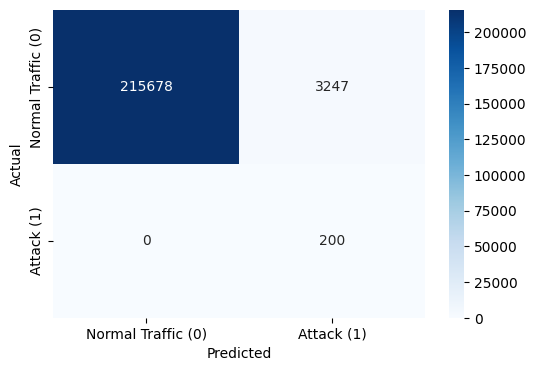

                precision    recall  f1-score   support

Normal Traffic       1.00      0.99      0.99    218925
        Attack       0.06      1.00      0.11       200

      accuracy                           0.99    219125
     macro avg       0.53      0.99      0.55    219125
  weighted avg       1.00      0.99      0.99    219125



In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [31]:
import numpy as np
import pandas as pd

# # Sanity: keep only those that truly flipped 1->0 according to the model
pred_orig = (final_model.predict(X_attack, verbose=0).ravel() > 0.5).astype(int)
pred_adv  = (final_model.predict(X_attacked_after,  verbose=0).ravel() > 0.5).astype(int)

# --- 2) Inverse-transform back to original feature units ---
# scaler_full was fit on the selected columns used by the model (Xtr_sel)
X_orig_success = scaler_full.inverse_transform(X_attack)
X_adv_success  = scaler_full.inverse_transform(X_attacked_after)

# --- 3) Build DataFrames with your desired columns and formatting ---
cols = selected_features

def make_df(X, preds):
    df = pd.DataFrame(X, columns=cols)
    return df

df_orig = make_df(X_orig_success, pred_orig)
df_adv  = make_df(X_adv_success,  pred_adv)

# --- 4) Show up to 10 examples in your exact format ---
n_show = min(10, len(df_orig))

print("Original Attack Samples (that later flipped 1→0):\n")
print(df_orig.head(n_show).to_string(index=True))

print("\nAdversarial Counterparts:\n")
print(df_adv.head(n_show).to_string(index=True))


Original Attack Samples (that later flipped 1→0):

   Number  HTTPS  Header_Length       IAT  ack_flag_number          Rate  Time_To_Live  ack_count  Tot sum  Tot size    Max         Std      Variance     AVG    Min
0   100.0   0.00          20.04  0.000072             0.01  13914.225053         63.78        1.0   6000.0     60.00   60.0    0.000000      0.000000   60.00   60.0
1   100.0   0.01          20.00  0.000141             0.02   7078.157855         65.47        2.0   6028.0     60.28   88.0    2.800000      7.840000   60.28   60.0
2   100.0   0.00          20.00  0.000038             1.00  26440.799344         64.00      100.0   6000.0     60.00   60.0    0.000000      0.000000   60.00   60.0
3   100.0   0.00          20.00  0.000025             1.00  49601.513718         64.00      100.0   6000.0     60.00   60.0    0.000000      0.000000   60.00   60.0
4   100.0   0.00          20.00  0.000021             1.00  50920.286512         64.00      100.0   6000.0     60.00   60.0 

# ZOO WITH REALISTIC VALUES

In [32]:
def zoo_attack_single(
    model,
    x0,
    y_true,
    steps=300,
    lr=0.05,
    h=1e-3,
    eps=0.5,
    norm="linf",          # "linf" or "l2"
    targeted=None,        # None for untargeted; otherwise target label in {0,1}
    clip_min=None,
    clip_max=None,
    early_stop=True,
    # ---- new args for realistic constraints ----
    scaler=None,               # StandardScaler-like used by enforce_iot_constraints_in_scaled_space
    feature_order=None,        # list of feature names in the same order as model inputs
    immutable_mask=None,       # 1D array same length as x0: 1.0 = keep immutable (do not change)
    mtu=1500,
    min_pkt=40,
    enforce_constraints=True
):
    """
    Runs ZOO on one sample while (optionally) enforcing realistic IoT constraints
    in scaled space using enforce_iot_constraints_in_scaled_space.
    Returns: x_adv, success(bool), queries(int), iters(int)
    """
    x = x0.copy()
    queries = 0
    d = x.size

    # Choose projector
    projector = project_linf if norm == "linf" else project_l2

    # Ensure immutable_mask is an array if provided
    if immutable_mask is not None:
        immutable_mask = np.asarray(immutable_mask, dtype=float).ravel()
        if immutable_mask.shape[0] != d:
            raise ValueError("immutable_mask must have same length as x0")

    # Initial check
    p0 = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred0 = int(p0 > 0.5)
    already_wrong = (y_pred0 != y_true)
    if targeted is None and already_wrong:
        return x, True, queries, 0  # already misclassified

    for t in range(1, steps + 1):
        # For targeted, define loss towards the target; for untargeted, towards the true label
        label_for_loss = targeted if targeted is not None else y_true

        # Zeroth-order gradient estimate of d(loss)/dx
        grad, q = finite_diff_grad(model, x, label_for_loss, h=h)
        queries += q

        # Update rule: untargeted -> ascend; targeted -> descend
        direction = +1.0 if targeted is None else -1.0
        x = x + direction * lr * grad

        # Project to epsilon-ball around original point
        x = projector(x0, x, eps)

        # Optional: keep within observed data range to avoid extreme z-scores
        if (clip_min is not None) and (clip_max is not None):
            x = np.minimum(np.maximum(x, clip_min), clip_max)

        # ----- Enforce IoT realistic constraints (in scaled space) -----
        if enforce_constraints and (scaler is not None) and (feature_order is not None):
            # enforce_iot_constraints_in_scaled_space expects a 2D array (n_samples, n_features)
            x_scaled = enforce_iot_constraints_in_scaled_space(
                X_scaled=x[None, :],
                scaler=scaler,
                feature_order=feature_order,
                mtu=mtu,
                min_pkt=min_pkt
            )[0]  # get the single-row back

            x = x_scaled

            # Re-apply immutables: keep original x0 entries for immutable fields
            if immutable_mask is not None:
                # immutable_mask==1.0 means do NOT change that feature
                imm_mask_bool = (immutable_mask == 1.0)
                if imm_mask_bool.any():
                    x[imm_mask_bool] = x0[imm_mask_bool]

            # If clipping by observed bounds is required again after enforcing constraints
            if (clip_min is not None) and (clip_max is not None):
                x = np.minimum(np.maximum(x, clip_min), clip_max)

            # Re-project to epsilon-ball because enforcing constraints can violate the ball
            x = projector(x0, x, eps)

        # Check success condition
        p = predict_proba(model, x[None, :])[0]; queries += 1
        y_pred = int(p > 0.5)
        success = (y_pred != y_true) if targeted is None else (y_pred == targeted)

        if early_stop and success:
            return x, True, queries, t

    # End of budget
    p = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred = int(p > 0.5)
    success = (y_pred != y_true) if targeted is None else (y_pred == targeted)
    return x, success, queries, steps


In [33]:
def run_zoo_attack(
    model,
    X,
    y,
    X_train_for_bounds=None,     # e.g., Xtr_sel to bound to observed range
    max_samples=100,
    eps=0.5,
    norm="linf",
    steps=300,
    lr=0.05,
    h=1e-3,
    targeted=None,
    only_on_correct=True,
    random_state=0,
    # ---- NEW args for constraints ----
    scaler=None,                # StandardScaler-like used by enforce_iot_constraints_in_scaled_space
    feature_order=None,         # list of feature names in same order as the model input
    immutable_mask=None,        # array same length as features; 1.0 means keep immutable
    enforce_constraints=True,   # whether to call enforce_iot_constraints_in_scaled_space
    mtu=1500,
    min_pkt=40,
):
    rng = np.random.default_rng(random_state)

    # Bounds from training data (optional but recommended for tabular)
    if X_train_for_bounds is not None:
        clip_min = X_train_for_bounds.min(axis=0)
        clip_max = X_train_for_bounds.max(axis=0)
    else:
        clip_min = clip_max = None

    # Decide which indices to attack
    y_pred_all = (predict_proba(model, X) > 0.5).astype(int)
    if only_on_correct:
        candidates = np.where(y_pred_all == y)[0]
    else:
        candidates = np.arange(len(y))
    rng.shuffle(candidates)
    idxs = candidates[:max_samples]

    successes = []
    queries_list = []
    iters_list = []
    X_adv = np.copy(X)

    for idx in tqdm(idxs, desc="ZOO attack", unit="sample"):
        x0 = X[idx]
        y_true = int(y[idx])

        x_adv, success, q, iters = zoo_attack_single(
            model=model,
            x0=x0,
            y_true=y_true,
            steps=steps,
            lr=lr,
            h=h,
            eps=eps,
            norm=norm,
            targeted=targeted,
            clip_min=clip_min,
            clip_max=clip_max,
            early_stop=True,
            # ---- forward new constraint args ----
            scaler=scaler,
            feature_order=feature_order,
            immutable_mask=immutable_mask,
            enforce_constraints=enforce_constraints,
            mtu=mtu,
            min_pkt=min_pkt
        )
        X_adv[idx] = x_adv
        successes.append(success)
        queries_list.append(q)
        iters_list.append(iters)

    # Metrics
    success_rate = np.mean(successes) if len(successes) else 0.0
    avg_queries = np.mean(queries_list) if queries_list else 0
    avg_iters = np.mean(iters_list) if iters_list else 0

    # Evaluate accuracy before/after (on attacked subset)
    acc_before = accuracy_score(y[idxs], y_pred_all[idxs])
    acc_after = accuracy_score(y[idxs], (predict_proba(model, X_adv[idxs]) > 0.5).astype(int))

    summary = {
        "num_attacked": len(idxs),
        "only_on_correct": only_on_correct,
        "targeted": targeted,
        "eps": eps,
        "norm": norm,
        "steps": steps,
        "lr": lr,
        "h": h,
        "success_rate": float(success_rate),
        "avg_queries": float(avg_queries),
        "avg_iters": float(avg_iters),
        "acc_before_on_subset": float(acc_before),
        "acc_after_on_subset": float(acc_after),
        "attacked_indices": idxs,
        "successes_bool": np.array(successes, dtype=bool),
        "queries_each": np.array(queries_list, dtype=int),
        "iters_each": np.array(iters_list, dtype=int),
        "X_adv": X_adv,  # full array with adversarial versions at attacked indices
    }
    return summary


In [38]:
feature_order = selected_features  # e.g. ['Offset','sTtl','sMeanPktSz','sHops','State']
scaler_project = scaler if 'scaler' in locals() else scaler_full
feat_idx = {c: i for i, c in enumerate(feature_order)}

# Build a 1/0 mask aligned to your selected_features
immutable = {'IAT', 'Tot sum', 'Tot size', 'Max', 'Std', 'Variance', 'AVG', 'Min'}  # add more names here if needed
mask_vec = np.array([1.0 if f in immutable else 0.0 for f in selected_features], dtype=np.float32)

zoo_attack_on_attacks = run_zoo_attack(
    model=final_model,
    X=X_attack,
    y=y_attack,
    X_train_for_bounds=None,   # or Xtr_sel if you want observed bounds
    targeted=0,
    only_on_correct=True,
    max_samples=min(200, len(y_attack)),
    eps=5.0,
    norm="linf",
    steps=200,
    lr=0.1,
    h=1e-3,
    random_state=42,
    # ---- new constraint args ----
    scaler=scaler_project,            # your StandardScaler used earlier
    feature_order=selected_features,  # list of names used by enforce_iot_constraints_in_scaled_space
    immutable_mask=mask_vec,          # e.g., immutable from FGSM
    enforce_constraints=True,
    mtu=1500,
    min_pkt=40
)


ZOO attack: 100%|██████████| 200/200 [2:40:41<00:00, 48.21s/sample]  


In [39]:
# --- 3) Evaluate ONLY on the actually ATTACKED subset (e.g. the 500 samples you attacked) ---
X_attack_adv = zoo_attack_on_attacks["X_adv"]  # full-length X_attack array where only attacked rows were changed
attacked_local_idx = np.array(zoo_attack_on_attacks["attacked_indices"], dtype=int)  # local indices inside X_attack that were attacked
success_flags = np.array(zoo_attack_on_attacks["successes_bool"], dtype=bool)
queries_each = np.array(zoo_attack_on_attacks["queries_each"], dtype=int)

# Defensive: if nothing was attacked, skip gracefully
if len(attacked_local_idx) == 0:
    print("No attacked samples were produced (attacked_indices is empty). Nothing to evaluate.")
else:
    # Subset BEFORE (original X_attack rows for the attacked subset)
    X_attacked_before = X_attack[attacked_local_idx]
    pred_before = (final_model.predict(X_attacked_before, verbose=0).ravel() > 0.5).astype(int)
    detection_rate_before = (pred_before == 1).mean()

    # Subset AFTER (adversarial rows in X_attack_adv corresponding to attacked_local_idx)
    X_attacked_after = X_attack_adv[attacked_local_idx]
    pred_after = (final_model.predict(X_attacked_after, verbose=0).ravel() > 0.5).astype(int)
    detection_rate_after = (pred_after == 1).mean()

    # Evasion: fraction predicted as 0 after attack on the attacked subset
    evasion_rate_subset = (pred_after == 0).mean()

    # Consistency checks / summary stats
    avg_queries_attacked = queries_each.mean() if queries_each.size else 0.0
    reported_success_rate = success_flags.mean() if success_flags.size else 0.0

    print(f"\n--- Evasion results (ONLY on ATTACKED SUBSET: {len(attacked_local_idx)} samples) ---")
    print(f"Detection rate BEFORE (attacked subset): {detection_rate_before:.3f}")
    print(f"Detection rate AFTER  (attacked subset): {detection_rate_after:.3f}")
    print(f"Evasion rate (attacked subset, pred==0 AFTER): {evasion_rate_subset:.3f}")
    print(f"Reported attack success rate (success_flags mean): {reported_success_rate:.3f}")
    print(f"Avg queries per attacked sample: {avg_queries_attacked:.1f}")

# --- 4) (optional) Put those adversarial attacks back into the FULL test matrix ---
# If you still want to inject only the attacked rows into the full test set for a full-report, map local->global:
global_attack_indices = np.where(attack_mask)[0]            # all global indices that were selected as "attack" set
# Map only if attacked_local_idx not empty
if len(attacked_local_idx):
    attacked_global_indices = global_attack_indices[attacked_local_idx]  # map local attacked indices -> global indices

    Xte_adv_full = Xte_sel.copy()
    # Replace only the attacked global rows with their adversarial versions
    Xte_adv_full[attacked_global_indices] = X_attack_adv[attacked_local_idx]

    # Evaluate on the full test set after injecting only the attacked adversarials
    test_preds_after = (final_model.predict(Xte_adv_full, verbose=0).ravel() > 0.5).astype(int)

    from sklearn.metrics import classification_report
    print("\nFinal Test Set Report AFTER injecting ONLY the attacked adversarials into the full test set:")
    print(classification_report(y_test, test_preds_after, zero_division=0))
else:
    print("No attacked rows to inject into full test set (skipping full-set report).")



--- Evasion results (ONLY on ATTACKED SUBSET: 200 samples) ---
Detection rate BEFORE (attacked subset): 1.000
Detection rate AFTER  (attacked subset): 0.995
Evasion rate (attacked subset, pred==0 AFTER): 0.005
Reported attack success rate (success_flags mean): 0.005
Avg queries per attacked sample: 6171.1

Final Test Set Report AFTER injecting ONLY the attacked adversarials into the full test set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    218925
           1       1.00      0.98      0.99    791607

    accuracy                           0.98   1010532
   macro avg       0.96      0.98      0.97   1010532
weighted avg       0.98      0.98      0.98   1010532



In [40]:
# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_attacked_after))
y_test_combined = np.hstack((y_test_normal, y_test_attack[:200]))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)

6848/6848 ━━━━━━━━━━━━━━━━━━━━ 6s 927us/step


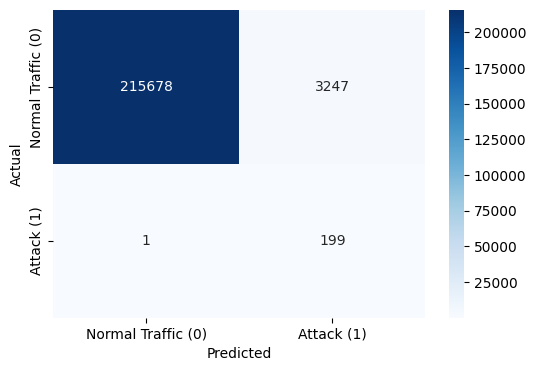

                precision    recall  f1-score   support

Normal Traffic       1.00      0.99      0.99    218925
        Attack       0.06      0.99      0.11       200

      accuracy                           0.99    219125
     macro avg       0.53      0.99      0.55    219125
  weighted avg       1.00      0.99      0.99    219125



In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [42]:
import numpy as np
import pandas as pd

# # Sanity: keep only those that truly flipped 1->0 according to the model
pred_orig = (final_model.predict(X_attack, verbose=0).ravel() > 0.5).astype(int)
pred_adv  = (final_model.predict(X_attacked_after,  verbose=0).ravel() > 0.5).astype(int)

# --- 2) Inverse-transform back to original feature units ---
# scaler_full was fit on the selected columns used by the model (Xtr_sel)
X_orig_success = scaler_full.inverse_transform(X_attack)
X_adv_success  = scaler_full.inverse_transform(X_attacked_after)

# --- 3) Build DataFrames with your desired columns and formatting ---
cols = selected_features

def make_df(X, preds):
    df = pd.DataFrame(X, columns=cols)
    return df

df_orig = make_df(X_orig_success, pred_orig)
df_adv  = make_df(X_adv_success,  pred_adv)

# --- 4) Show up to 10 examples in your exact format ---
n_show = min(10, len(df_orig))

print("Original Attack Samples (that later flipped 1→0):\n")
print(df_orig.head(n_show).to_string(index=True))

print("\nAdversarial Counterparts:\n")
print(df_adv.head(n_show).to_string(index=True))


Original Attack Samples (that later flipped 1→0):

   Number  HTTPS  Header_Length       IAT  ack_flag_number          Rate  Time_To_Live  ack_count  Tot sum  Tot size    Max         Std      Variance     AVG    Min
0   100.0   0.00          20.04  0.000072             0.01  13914.225053         63.78        1.0   6000.0     60.00   60.0    0.000000      0.000000   60.00   60.0
1   100.0   0.01          20.00  0.000141             0.02   7078.157855         65.47        2.0   6028.0     60.28   88.0    2.800000      7.840000   60.28   60.0
2   100.0   0.00          20.00  0.000038             1.00  26440.799344         64.00      100.0   6000.0     60.00   60.0    0.000000      0.000000   60.00   60.0
3   100.0   0.00          20.00  0.000025             1.00  49601.513718         64.00      100.0   6000.0     60.00   60.0    0.000000      0.000000   60.00   60.0
4   100.0   0.00          20.00  0.000021             1.00  50920.286512         64.00      100.0   6000.0     60.00   60.0 

# Feature Selection with Random Forest

In [25]:
data.head(10)

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,25.6,6,67.2,111.733096,0.0,0.1,0.0,0.1,0.6,0.0,...,8010,60,2962,801.0,1015.627338,801.0,0.008950,10,1.031499e+06,0
1,32.0,6,64.0,905.799374,0.0,0.0,0.0,0.0,1.0,0.0,...,20932,1514,4410,2093.2,1221.060814,2093.2,0.001122,10,1.490990e+06,0
2,32.0,6,80.8,931.177763,0.0,0.0,0.0,0.0,1.0,0.0,...,25276,66,5858,2527.6,1936.690602,2527.6,0.001091,10,3.750770e+06,0
3,32.0,6,232.0,1419.440252,0.0,0.0,0.0,0.0,1.0,0.0,...,660,66,66,66.0,0.000000,66.0,0.000814,10,0.000000e+00,0
4,32.0,6,181.2,211.585617,0.0,0.0,0.0,0.0,1.0,0.0,...,3556,66,1514,355.6,610.530407,355.6,0.004726,10,3.727474e+05,0
5,32.0,6,64.0,495.979945,0.0,0.0,0.0,0.2,1.0,0.0,...,13420,156,1514,1342.0,431.968106,1342.0,0.003802,10,1.865964e+05,0
6,29.6,6,213.5,684.650191,0.0,0.0,0.0,0.0,0.9,0.0,...,654,60,66,65.4,1.897367,65.4,0.002290,10,3.600000e+00,0
7,29.6,6,215.2,266.667345,0.0,0.0,0.0,0.0,0.9,0.0,...,672,66,78,67.2,3.794733,67.2,0.004039,10,1.440000e+01,0
8,17.6,17,110.0,161.801678,0.0,0.0,0.0,0.1,0.4,0.0,...,798,60,156,79.8,29.697737,79.8,0.006195,10,8.819556e+02,0
9,24.8,6,145.0,58.480835,0.0,0.0,0.0,0.1,0.7,0.0,...,922,62,230,92.2,58.972310,92.2,0.017100,10,3.477733e+03,0


In [27]:
X_df = data.drop(columns=['Label'])  # Keep as DataFrame
y = data['Label']

X_df.columns

Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance'],
      dtype='object')

In [28]:
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest model for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_df, y)

feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_df.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
37,Number,0.171143
16,HTTPS,0.114059
0,Header_Length,0.101207
36,IAT,0.073624
8,ack_flag_number,0.071979
3,Rate,0.071440
2,Time_To_Live,0.067054
11,ack_count,0.059970
30,Tot sum,0.044094
35,Tot size,0.042722


In [30]:
len(feature_importance_df)

39

In [29]:
# ----- Your fixed best hyperparameters -----
best_params = {
    'epochs': 10, 
    'n_layers': 4, 
    'n_units_l0': 128, 'dropout_l0': 0.0, 
    'n_units_l1': 128, 'dropout_l1': 0.1, 
    'n_units_l2': 8, 'dropout_l2': 0.0, 
    'n_units_l3': 8, 'dropout_l3': 0.0,
    'learning_rate': 1e-3,
    'batch_size': 32
}


Best k = 31 with mean CV macro F1 = 0.9707


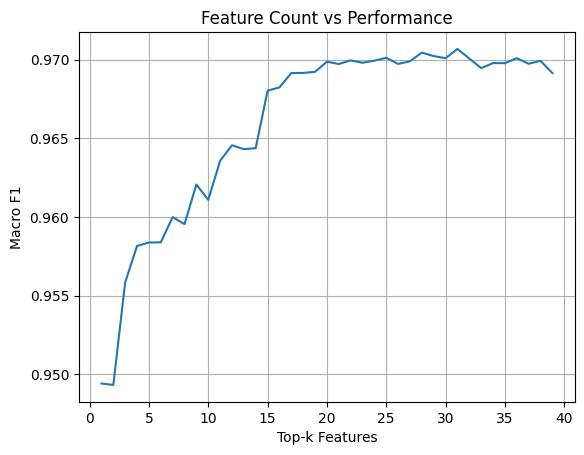

Selected features: ['Number', 'HTTPS', 'Header_Length', 'IAT', 'ack_flag_number', 'Rate', 'Time_To_Live', 'ack_count', 'Tot sum', 'Tot size', 'Max', 'Std', 'Variance', 'AVG', 'Min', 'psh_flag_number', 'syn_count', 'TCP', 'syn_flag_number', 'HTTP', 'ARP', 'DNS', 'LLC', 'rst_flag_number', 'UDP', 'rst_count', 'IPv', 'fin_flag_number', 'fin_count', 'ICMP', 'Protocol Type']
Final Test Set Report (using best_k features):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    218925
           1       1.00      0.98      0.99    791607

    accuracy                           0.98   1010532
   macro avg       0.96      0.98      0.97   1010532
weighted avg       0.98      0.98      0.98   1010532



In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# ----- Split once: trainval / test -----
X_df = data.drop(columns=['Label'])
y = data['Label'].values

X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y, test_size=0.2, stratify=y, random_state=42
)

# ----- Model builder using your fixed params -----
def build_model(input_dim: int):
    m = Sequential()
    m.add(Input(shape=(input_dim,)))
    for i in range(best_params['n_layers']):
        units = best_params.get(f"n_units_l{i}")
        dr = best_params.get(f"dropout_l{i}", 0.0)
        m.add(Dense(units, activation='relu'))
        if dr and dr > 0:
            m.add(Dropout(dr))
    m.add(Dense(1, activation='sigmoid'))
    m.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy', metrics=['accuracy'])
    return m

# ----- Prepare top-k feature order (from your RandomForest importances) -----
top_features = (
    feature_importance_df.sort_values('Importance', ascending=False)['Feature']
    .tolist()
)
top_features = [f for f in top_features if f in X_trainval_df.columns]
max_k = len(top_features)

# ----- CV eval for a given k (on trainval only; scaling inside each fold) -----
def cv_macro_f1_for_k(k: int, seed: int = 42, val_size: float = 0.2):
    feats = top_features[:k]
    Xk = X_trainval_df[feats].values
    yk = y_trainval

    # single stratified hold-out split (no cross-validation)
    X_tr, X_va, y_tr, y_va = train_test_split(
        Xk, yk, test_size=val_size, stratify=yk, random_state=seed
    )

    scaler = StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_va = scaler.transform(X_va)

    model = build_model(input_dim=X_tr.shape[1])
    early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        callbacks=[early]
    )

    preds = (model.predict(X_va, verbose=0).ravel() > 0.5).astype(int)
    rep = classification_report(y_va, preds, output_dict=True, zero_division=0)
    f1 = rep['macro avg']['f1-score']

    # No CV: return f1 and 0.0 for std to preserve signature compatibility
    return float(f1), 0.0


# ----- Search k = 1..max_k -----
results = []
for k in range(1, max_k + 1):
    mean_f1, std_f1 = cv_macro_f1_for_k(k)
    results.append({'k': k, 'mean_macro_f1': mean_f1, 'std_macro_f1': std_f1})

df_k = pd.DataFrame(results)
best_row = df_k.iloc[df_k['mean_macro_f1'].idxmax()]
best_k = int(best_row['k'])
print(f"Best k = {best_k} with mean CV macro F1 = {best_row['mean_macro_f1']:.4f}")

# ----- Plot performance vs k -----
plt.figure()
plt.plot(df_k['k'], df_k['mean_macro_f1'])
plt.xlabel('Top-k Features')
plt.ylabel('Macro F1')
plt.title('Feature Count vs Performance')
plt.grid(True)
plt.show()

# ----- Final train on all trainval with best_k features; evaluate once on test -----
selected_features = top_features[:best_k]
print("Selected features:", selected_features)

Xtr_sel = X_trainval_df[selected_features].values
Xte_sel = X_test_df[selected_features].values

scaler_full = StandardScaler().fit(Xtr_sel)
Xtr_sel = scaler_full.transform(Xtr_sel)
Xte_sel = scaler_full.transform(Xte_sel)

final_model = build_model(input_dim=Xtr_sel.shape[1])
final_model.fit(
    Xtr_sel, y_trainval,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0
)

test_preds = (final_model.predict(Xte_sel, verbose=0).ravel() > 0.5).astype(int)
final_report = classification_report(y_test, test_preds, zero_division=0)
print("Final Test Set Report (using best_k features):")
print(final_report)


In [34]:
results_df = pd.DataFrame(results)
results_df

,k,mean_macro_f1,std_macro_f1
0,1,0.949403,0.0
1,2,0.949312,0.0
2,3,0.955838,0.0
3,4,0.958153,0.0
4,5,0.958371,0.0
5,6,0.958384,0.0
6,7,0.959988,0.0
7,8,0.959542,0.0
8,9,0.962060,0.0
9,10,0.961082,0.0


# WYBRANE 15 NAJWAŻNIEJSZYCH CECH

In [35]:
# ----- Final train on all trainval with best_k features; evaluate once on test -----
selected_features = top_features[:15]
print("Selected features:", selected_features)

Xtr_sel = X_trainval_df[selected_features].values
Xte_sel = X_test_df[selected_features].values

scaler_full = StandardScaler().fit(Xtr_sel)
Xtr_sel = scaler_full.transform(Xtr_sel)
Xte_sel = scaler_full.transform(Xte_sel)

final_model = build_model(input_dim=Xtr_sel.shape[1])
final_model.fit(
    Xtr_sel, y_trainval,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

test_preds = (final_model.predict(Xte_sel, verbose=1).ravel() > 0.5).astype(int)
final_report = classification_report(y_test, test_preds, zero_division=0)
print("Final Test Set Report (using best_k features):")
print(final_report)

Selected features: ['Number', 'HTTPS', 'Header_Length', 'IAT', 'ack_flag_number', 'Rate', 'Time_To_Live', 'ack_count', 'Tot sum', 'Tot size', 'Max', 'Std', 'Variance', 'AVG', 'Min']
Epoch 1/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 143s 1ms/step - accuracy: 0.9717 - loss: 0.0752
Epoch 2/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 142s 1ms/step - accuracy: 0.9752 - loss: 0.0663
Epoch 3/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 142s 1ms/step - accuracy: 0.9765 - loss: 0.0637
Epoch 4/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 140s 1ms/step - accuracy: 0.9769 - loss: 0.0625
Epoch 5/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 138s 1ms/step - accuracy: 0.9770 - loss: 0.0625
Epoch 6/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 139s 1ms/step - accuracy: 0.9772 - loss: 0.0617
Epoch 7/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 142s 1ms/step - accuracy: 0.9773 - loss: 0.0613
Epoch 8/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 139s 1ms/step - accuracy: 0.9775 - loss: 0.0610
Epoch 9/10
126317/126317 ━━━━━━━━━━━━━━━━━━━━ 139s 1ms/step - accu

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Calculate metrics
accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='weighted')  # Use 'macro' or 'micro' for different averaging
recall = recall_score(y_test, test_preds, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


Test Accuracy: 97.78%
Test Precision: 97.90%
Test Recall: 97.78%


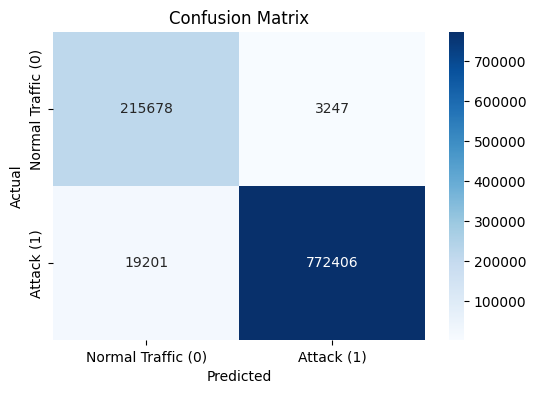

                precision    recall  f1-score   support

Normal Traffic       0.92      0.99      0.95    218925
        Attack       1.00      0.98      0.99    791607

      accuracy                           0.98   1010532
     macro avg       0.96      0.98      0.97   1010532
  weighted avg       0.98      0.98      0.98   1010532



In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test, test_preds, target_names=['Normal Traffic', 'Attack']))


In [38]:
# Save the trained model
final_model.save("CIC_IOT_csv_final.keras")